<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [24]:
!pip install gdown -q

In [25]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=a7bffe02-fdeb-4dab-a0df-5b475f1f947a
To: /home/ivan/AIHW/uplift/Data.zip
100%|████████████████████████████████████████| 289M/289M [00:36<00:00, 7.87MB/s]


'Data.zip'

In [95]:
import zipfile


#with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/')


<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [1]:
import pandas as pd

In [3]:
# ваш код здесь
campaings = pd.read_csv('CAMPAINGS.csv')
campaings

,Unnamed: 0,campaing_id,product_id,channel
0,0,iddqd,1,push
1,1,idclip,1,sms
2,2,iddt,1,banner
3,3,idkfa,1,other_ads


In [5]:
campaings['product_id'].duplicated().sum()

3

In [7]:
campaings['product_id'].unique()

array([1])

In [9]:
campaings.columns

Index(['Unnamed: 0', 'campaing_id', 'product_id', 'channel'], dtype='object')

In [11]:
campaings = campaings[['campaing_id', 'channel']]

In [13]:
campaings_dict = dict(zip(campaings['campaing_id'], campaings['channel']))
campaings_dict

{'iddqd': 'push', 'idclip': 'sms', 'iddt': 'banner', 'idkfa': 'other_ads'}

In [15]:
features = pd.read_csv('AGGS_FINAL.csv')
features.head()

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [17]:
sorted(features['report_dt'].unique())

['2024-09-30',
 '2024-11-30',
 '2024-12-31',
 '2025-01-31',
 '2025-02-28',
 '2025-03-31']

In [19]:
features['user_id'].duplicated().sum()

2300000

In [21]:
features[features['report_dt'] == '2025-01-31']['user_id'].duplicated().sum()

0

In [23]:
for i in sorted(features['report_dt'].unique()):
    print(i)
    print(features[features['report_dt'] == i].shape)
    print("количество дублей по user_id: ", features[features['report_dt'] == i]['user_id'].duplicated().sum())
    print()

2024-09-30
(460000, 14)
количество дублей по user_id:  0

2024-11-30
(460000, 14)
количество дублей по user_id:  0

2024-12-31
(460000, 14)
количество дублей по user_id:  0

2025-01-31
(460000, 14)
количество дублей по user_id:  0

2025-02-28
(460000, 14)
количество дублей по user_id:  0

2025-03-31
(460000, 14)
количество дублей по user_id:  0



Данные о продажах есть с 01 ноября, а коммуникации были получены 04 - 08 ноября 2024.

Поэтому для обучения можем использовать данные о признаках клиентов от 2024-09-30

In [26]:
features.columns

Index(['Unnamed: 0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'report_dt', 'user_id', 'age', 'city'],
      dtype='object')

In [28]:
features[features['report_dt'] == '2024-09-30'].shape

(460000, 14)

In [30]:
features = features[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'report_dt', 'user_id', 'age', 'city']]

In [32]:
features.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [305]:
features_january = features[features['report_dt'] == '2025-01-31']
features_january.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
19,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,2025-01-31,25872,42,Moscow
48,1.262071,-0.590011,-1.487096,-0.966672,2.740715,0.312791,-0.356535,-0.539563,1.401530,2025-01-31,4107442,28,Smolensk
66,-6.942073,0.107627,1.760962,4.424731,1.980637,0.238544,-1.329872,0.288694,-1.625620,2025-01-31,2047420,32,Moscow
67,-2.200147,0.694959,-1.620087,4.003986,0.808261,0.214216,-0.330887,-1.386118,1.525752,2025-01-31,1120643,22,Ufa


In [40]:
features_september = features[features['report_dt'] == '2024-09-30']
features_september.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
10,-4.310515,1.935966,3.863338,-0.153695,0.607030,3.144800,2.345112,1.640440,-2.495154,2024-09-30,4118994,30,Smolensk
12,0.073232,-2.220851,-0.132811,-0.982687,-1.234086,1.788496,0.986282,0.862095,-0.434219,2024-09-30,4059009,28,Ufa
17,0.746437,0.993587,0.724606,-1.706551,1.903652,-1.056543,-0.257320,1.985526,0.849804,2024-09-30,114654,28,Ufa
22,-0.523940,-1.198285,0.153114,0.447893,0.178328,0.159046,-0.054638,-1.202937,-0.410140,2024-09-30,50103,21,Ufa
25,1.326389,-1.154658,-3.043242,1.331015,0.206358,1.464790,1.351006,1.224259,0.406671,2024-09-30,4074594,44,Ufa


In [42]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760000 entries, 0 to 2759999
Data columns (total 13 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x1         float64
 1   x2         float64
 2   x3         float64
 3   x4         float64
 4   x5         float64
 5   x6         float64
 6   x7         float64
 7   x8         float64
 8   x9         float64
 9   report_dt  object 
 10  user_id    int64  
 11  age        int64  
 12  city       object 
dtypes: float64(9), int64(2), object(2)
memory usage: 273.7+ MB


In [46]:
contracts = pd.read_csv('CONTRACTS_FINAL.csv')
contracts.head()

,Unnamed: 0,user_id,contract_date,product_id,contract_id
0,39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,9286,103088,2024-11-13,1,0001_2024-11-13_103088
3,45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,150378,52269,2024-11-17,1,0001_2024-11-17_52269


In [48]:
contracts.columns

Index(['Unnamed: 0', 'user_id', 'contract_date', 'product_id', 'contract_id'], dtype='object')

In [50]:
contracts = contracts[['user_id', 'contract_date', 'product_id', 'contract_id']]
contracts.head(2)

,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035


In [52]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286316 entries, 0 to 286315
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        286316 non-null  int64 
 1   contract_date  286316 non-null  object
 2   product_id     286316 non-null  int64 
 3   contract_id    286316 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.7+ MB


In [54]:
contracts['product_id'].unique()

array([1])

In [56]:
contracts['user_id'].duplicated().sum()

0

In [58]:
sorted(contracts['contract_date'].unique())

['2024-11-01',
 '2024-11-02',
 '2024-11-03',
 '2024-11-04',
 '2024-11-05',
 '2024-11-06',
 '2024-11-07',
 '2024-11-08',
 '2024-11-10',
 '2024-11-11',
 '2024-11-12',
 '2024-11-13',
 '2024-11-14',
 '2024-11-15',
 '2024-11-16',
 '2024-11-17',
 '2024-11-23',
 '2024-11-24',
 '2024-11-25',
 '2024-11-26',
 '2024-11-27',
 '2024-11-28']

Данные о продажах есть с 01 ноября, а коммуникации были получены 04 - 08 ноября 2024

Но старт компании суть 01 ноября.


In [62]:
people_in_campaings = pd.read_csv('PEOPLE_IN_CAMPAINGS_FINAL.csv')
people_in_campaings.head()

,Unnamed: 0,campaing_id,user_id,t_flag,delivery_date
0,29299,idclip,1099975,1,2024-11-06
1,36627,iddqd,1162,1,2024-11-08
2,134015,iddqd,42991,1,2024-11-07
3,57441,idclip,142343,0,unknown
4,48671,iddqd,24623,0,unknown


In [64]:
people_in_campaings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520000 entries, 0 to 519999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     520000 non-null  int64 
 1   campaing_id    520000 non-null  object
 2   user_id        520000 non-null  int64 
 3   t_flag         520000 non-null  int64 
 4   delivery_date  520000 non-null  object
dtypes: int64(3), object(2)
memory usage: 19.8+ MB


In [66]:
sorted(people_in_campaings['delivery_date'].unique())

['2024-11-04',
 '2024-11-05',
 '2024-11-06',
 '2024-11-07',
 '2024-11-08',
 'unknown']

признаки клиентов есть на 2024-09-30,
а коммуникация проводилась с 04 - 08 ноября 2024

In [69]:
people_in_campaings.columns

Index(['Unnamed: 0', 'campaing_id', 'user_id', 't_flag', 'delivery_date'], dtype='object')

In [71]:
people_in_campaings = people_in_campaings[['campaing_id', 'user_id', 't_flag', 'delivery_date']]

In [73]:
people_in_campaings.head()

,campaing_id,user_id,t_flag,delivery_date
0,idclip,1099975,1,2024-11-06
1,iddqd,1162,1,2024-11-08
2,iddqd,42991,1,2024-11-07
3,idclip,142343,0,unknown
4,iddqd,24623,0,unknown


In [75]:
people_in_campaings.shape

(520000, 4)

In [77]:
people_in_campaings['user_id'].duplicated().sum()

60000

Нашли 60000 дублей по значению 'user_id' в данных рекламных кампаниях. Всего 460 000 различных клиентов.
Далее разберёмся кто из пользователей и почему попал в разные компании или получил рекламу более 1 раза по одной кампании.

In [80]:
duplicate_people = people_in_campaings[people_in_campaings['user_id'].duplicated(keep=False)]

In [82]:
duplicate_people.shape

(120000, 4)

In [84]:
duplicate_people['campaing_id'].unique()

array(['iddqd', 'idclip'], dtype=object)

In [86]:
duplicate_people[duplicate_people['campaing_id'] == 'iddqd'].shape

(60000, 4)

In [88]:
campaings_dict['iddqd']

'push'

In [90]:
campaings_dict['idclip']

'sms'

In [92]:
duplicate_people[duplicate_people['campaing_id'] == 'iddqd'].duplicated().sum()

0

Мы установили, что из 460 000 различных клиентов 60 000 клиентов участвовали одновременно в двух кампаниях ('push' и 'sms').

На выходе у вас должна появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt, target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов

report_dt = '2024-09-30'

In [97]:
features_september.shape

(460000, 13)

In [99]:
people_in_campaings.shape

(520000, 4)

In [101]:
contracts.shape

(286316, 4)

286316 продаж, где каждой продаже соответствует уникальный клиент

In [104]:
contracts.head(2)

,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035


client_id, report_dt, target

campaings_dict

In [107]:
df = people_in_campaings.copy()
df['channel'] = df['campaing_id'].apply(lambda x: campaings_dict[x])

In [109]:
df.head(2)

,campaing_id,user_id,t_flag,delivery_date,channel
0,idclip,1099975,1,2024-11-06,sms
1,iddqd,1162,1,2024-11-08,push


In [111]:
df['report_dt'] = '2024-09-30'

In [113]:
df.head(2)

,campaing_id,user_id,t_flag,delivery_date,channel,report_dt
0,idclip,1099975,1,2024-11-06,sms,2024-09-30
1,iddqd,1162,1,2024-11-08,push,2024-09-30


In [115]:
contracts.head(2)

,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035


In [117]:
df = pd.merge(df, contracts, on='user_id', how='left')
df.head()

,campaing_id,user_id,t_flag,delivery_date,channel,report_dt,contract_date,product_id,contract_id
0,idclip,1099975,1,2024-11-06,sms,2024-09-30,2024-11-11,1.0,0001_2024-11-11_1099975
1,iddqd,1162,1,2024-11-08,push,2024-09-30,2024-11-13,1.0,0001_2024-11-13_1162
2,iddqd,42991,1,2024-11-07,push,2024-09-30,NaN,NaN,NaN
3,idclip,142343,0,unknown,sms,2024-09-30,2024-11-17,1.0,0001_2024-11-17_142343
4,iddqd,24623,0,unknown,push,2024-09-30,NaN,NaN,NaN


In [119]:
df['client_id'] = df['user_id']

In [121]:
df.shape

(520000, 10)

In [123]:
df['t_flag'].unique()

array([1, 0])

Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1.

't_flag' - флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)

In [126]:
import numpy as np
import pandas as pd

def find_target(x):
    if x['t_flag'] == 0:
        if str(x['contract_date']) in ['NaN', 'nan', 'None', 'Null', 'NULL', 'unknown']:
            return 0
        elif int(x['contract_date'][-2:]) <= 21:
            return 1
        else:
            return 0
    else:
        if str(x['contract_date']) in ['NaN', 'nan', 'None', 'Null', 'NULL', 'unknown']:
            return 0
        elif int(x['contract_date'][-2:]) < int(x['delivery_date'][-2:]):
            return 0
        elif int(x['contract_date'][-2:]) - int(x['delivery_date'][-2:]) <= 14:
            return 1
        else:
            return 0


In [128]:
df['target'] = df[['t_flag', 'delivery_date', 'contract_date']].apply(lambda x: find_target(x), axis=1)

In [130]:
df.head()

,campaing_id,user_id,t_flag,delivery_date,channel,report_dt,contract_date,product_id,contract_id,client_id,target
0,idclip,1099975,1,2024-11-06,sms,2024-09-30,2024-11-11,1.0,0001_2024-11-11_1099975,1099975,1
1,iddqd,1162,1,2024-11-08,push,2024-09-30,2024-11-13,1.0,0001_2024-11-13_1162,1162,1
2,iddqd,42991,1,2024-11-07,push,2024-09-30,NaN,NaN,NaN,42991,0
3,idclip,142343,0,unknown,sms,2024-09-30,2024-11-17,1.0,0001_2024-11-17_142343,142343,1
4,iddqd,24623,0,unknown,push,2024-09-30,NaN,NaN,NaN,24623,0


In [132]:
df['target'].describe()

count    520000.000000
mean          0.457481
std           0.498189
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

In [134]:
df.columns

Index(['campaing_id', 'user_id', 't_flag', 'delivery_date', 'channel',
       'report_dt', 'contract_date', 'product_id', 'contract_id', 'client_id',
       'target'],
      dtype='object')

In [136]:
data = df[['client_id', 'report_dt', 't_flag', 'channel', 'target']]
data.head()

,client_id,report_dt,t_flag,channel,target
0,1099975,2024-09-30,1,sms,1
1,1162,2024-09-30,1,push,1
2,42991,2024-09-30,1,push,0
3,142343,2024-09-30,0,sms,1
4,24623,2024-09-30,0,push,0


In [138]:
for channel in data['channel'].unique():
    print(channel)
    target = data[data['channel']== channel]['target']
    print(target.describe())
    print()

sms
count    120000.000000
mean          0.443042
std           0.496747
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

push
count    160000.000000
mean          0.401944
std           0.490292
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

banner
count    120000.000000
mean          0.501725
std           0.499999
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

other_ads
count    120000.000000
mean          0.501725
std           0.499999
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64



Выше мы установили, что 60 000 клиетов направили рекламу по двум каналам (push и sms). Чтобы продолжить анализ нужно удалить этих клиентов, в противном случае мы получим некорректные выводы, не сможем определить какой именно канал и как повлиял на них.

In [141]:
duplicate_people['user_id'] #теперь удалим 120 000 записей (это клиенты получившие рекламу сразу из двух каналов)

1           1162
2          42991
3         142343
11         53272
13         28098
           ...  
519980     16383
519986     92223
519993     81278
519996    131927
519999     85450
Name: user_id, Length: 120000, dtype: int64

In [143]:
data.shape

(520000, 5)

In [145]:
fixed_data = data[~data['client_id'].isin(duplicate_people['user_id'])] 

fixed_data.shape

(400000, 5)

In [147]:
for channel in fixed_data['channel'].unique():
    print(channel)
    target = fixed_data[fixed_data['channel']== channel]['target']
    print(target.describe())
    print()

sms
count    60000.000000
mean         0.201167
std          0.400876
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

push
count    100000.000000
mean          0.283430
std           0.450666
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

banner
count    120000.000000
mean          0.501725
std           0.499999
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64

other_ads
count    120000.000000
mean          0.501725
std           0.499999
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: target, dtype: float64



In [149]:
fixed_data.head()

,client_id,report_dt,t_flag,channel,target
0,1099975,2024-09-30,1,sms,1
4,24623,2024-09-30,0,push,0
5,4001330,2024-09-30,0,banner,0
6,2008409,2024-09-30,1,other_ads,0
7,4045746,2024-09-30,1,banner,0


In [152]:
for channel in fixed_data['channel'].unique():
    print(channel)
    d_c = fixed_data[fixed_data['channel'] == channel]
    
    print('Объектов в канале', d_c.shape[0])
   
    print(d_c['t_flag'].value_counts())
    print(d_c['target'].value_counts())
    
   
    print('\n\n')

sms
Объектов в канале 60000
t_flag
1    60000
Name: count, dtype: int64
target
0    47930
1    12070
Name: count, dtype: int64



push
Объектов в канале 100000
t_flag
0    80000
1    20000
Name: count, dtype: int64
target
0    71657
1    28343
Name: count, dtype: int64



banner
Объектов в канале 120000
t_flag
0    60000
1    60000
Name: count, dtype: int64
target
1    60207
0    59793
Name: count, dtype: int64



other_ads
Объектов в канале 120000
t_flag
1    60000
0    60000
Name: count, dtype: int64
target
1    60207
0    59793
Name: count, dtype: int64





Мы показали, что "сломался" канал SMS, так для него не осталось ни одного клиента из контрольной группы.
Далее не будем моделировать аплифт для канала SMS.
Удалим канал из обучающей выборки.

In [155]:
fixed_data.shape

(400000, 5)

In [157]:
fixed_data = fixed_data[fixed_data['channel'] != 'sms'] 

fixed_data.shape

(340000, 5)

In [159]:
fixed_data['channel'].value_counts()

channel
banner       120000
other_ads    120000
push         100000
Name: count, dtype: int64

**Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)**

In [162]:
for channel in fixed_data['channel'].unique():
    print(channel)
    d_c = fixed_data[fixed_data['channel'] == channel]

    t_g_mean = d_c[d_c['t_flag'] == 1]['target'].mean()
    c_g_mean = d_c[d_c['t_flag'] == 0]['target'].mean()
    print(f'Эффективность кампании {channel} по uplift: {t_g_mean - c_g_mean}')
    
    print('\n')

push
Эффективность кампании push по uplift: 0.40640000000000004


banner
Эффективность кампании banner по uplift: 0.20198333333333335


other_ads
Эффективность кампании other_ads по uplift: 0.20198333333333335




### ваши выводы здесь

Данные о продажах есть с 01 ноября, а коммуникации были получены 04 - 08 ноября 2024.
Поэтому для обучения будем использовать данные о признаках клиентов от 2024-09-30, а старт компании для обучения суть 01 ноября.

Выше мы нашли 60000 дублей по значению 'user_id' в рекламных кампаниях.
Всего у нас 460 000 различных клиентов.
Мы установили, что из 460 000 различных клиентов 60 000 клиентов участвовали одновременно в двух кампаниях ('push' и 'sms').
Чтобы продолжить анализ мы удалили таких клиентов. Если не уадалять их, то мы получим некорректные выводы, не сможем определить какой именно канал и как повлиял на них.
Затем мы показали, что "сломался" канал SMS, так для него не осталось ни одного клиента из контрольной группы. 

Далее мы не будем моделировать аплифт для канала SMS. Мы удалили канал SMS из обучающей выборки.


Эффективность кампании push по uplift: 0.40.

Эффективность кампании banner по uplift: 0.20.

Эффективность кампании other_ads по uplift: 0.20.

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [167]:
# ваш код здесь
fixed_data.head()

,client_id,report_dt,t_flag,channel,target
4,24623,2024-09-30,0,push,0
5,4001330,2024-09-30,0,banner,0
6,2008409,2024-09-30,1,other_ads,0
7,4045746,2024-09-30,1,banner,0
9,2101471,2024-09-30,0,other_ads,1


In [169]:
features_september.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
10,-4.310515,1.935966,3.863338,-0.153695,0.607030,3.144800,2.345112,1.640440,-2.495154,2024-09-30,4118994,30,Smolensk
12,0.073232,-2.220851,-0.132811,-0.982687,-1.234086,1.788496,0.986282,0.862095,-0.434219,2024-09-30,4059009,28,Ufa
17,0.746437,0.993587,0.724606,-1.706551,1.903652,-1.056543,-0.257320,1.985526,0.849804,2024-09-30,114654,28,Ufa
22,-0.523940,-1.198285,0.153114,0.447893,0.178328,0.159046,-0.054638,-1.202937,-0.410140,2024-09-30,50103,21,Ufa
25,1.326389,-1.154658,-3.043242,1.331015,0.206358,1.464790,1.351006,1.224259,0.406671,2024-09-30,4074594,44,Ufa


In [171]:
final_data = pd.merge(fixed_data, features_september, left_on='client_id', right_on='user_id', how='inner')
final_data.head(2)

,client_id,report_dt_x,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt_y,user_id,age,city
0,24623,2024-09-30,0,push,0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,24623,39,Ufa
1,4001330,2024-09-30,0,banner,0,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,2024-09-30,4001330,30,Smolensk


In [173]:
final_data.columns

Index(['client_id', 'report_dt_x', 't_flag', 'channel', 'target', 'x1', 'x2',
       'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'report_dt_y', 'user_id',
       'age', 'city'],
      dtype='object')

In [175]:
final_data = final_data[['x1', 'x2',
       'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age', 'city', 't_flag', 'channel', 'target']]
final_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city,t_flag,channel,target
0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa,0,push,0
1,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,30,Smolensk,0,banner,0
2,-1.952636,-0.479671,1.067760,-1.521329,-0.687298,0.327018,1.052708,1.244605,-0.886796,25,Moscow,1,other_ads,0
3,1.768029,-1.560275,0.533826,-1.815031,-0.456184,0.274609,0.077484,0.452296,-0.224605,21,Ufa,1,banner,0
4,2.365226,-1.303713,0.133301,2.098386,-0.000000,0.285846,0.545567,0.293677,-0.312559,36,Ufa,0,other_ads,1


In [177]:
final_data.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,t_flag,target
count,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000,340000.000000
mean,0.037617,-0.413541,0.431752,-0.317699,0.173456,-0.000058,0.235802,0.235035,-0.011647,32.512009,0.411765,0.437521
std,1.553318,1.672666,1.639912,1.522389,1.110328,0.997721,1.198158,1.128205,1.117759,7.497181,0.492154,0.496082
min,-6.600556,-7.048631,-6.595832,-6.967769,-7.178475,-4.415184,-3.498235,-4.315174,-5.094654,20.000000,0.000000,0.000000
25%,-1.005078,-1.579707,-0.704867,-1.405696,-0.392094,-0.673678,-0.787013,-0.894631,-0.755064,26.000000,0.000000,0.000000
50%,0.208848,-0.439750,0.455277,-0.343594,0.000000,0.002701,0.359600,0.547460,-0.096955,33.000000,0.000000,0.000000
75%,1.170727,0.742199,1.570705,0.766357,0.803148,0.674588,1.182099,1.119127,0.635112,39.000000,1.000000,1.000000
max,5.458816,6.390556,7.075373,6.664877,6.697053,4.365279,4.603380,5.905419,5.982396,45.000000,1.000000,1.000000


In [179]:
final_data['city'].value_counts()

city
Smolensk    128951
Ufa         105930
Moscow      105119
Name: count, dtype: int64

In [181]:
fixed_data.shape

(340000, 5)

In [183]:
final_data.shape

(340000, 14)

In [185]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340000 entries, 0 to 339999
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   x1       340000 non-null  float64
 1   x2       340000 non-null  float64
 2   x3       340000 non-null  float64
 3   x4       340000 non-null  float64
 4   x5       340000 non-null  float64
 5   x6       340000 non-null  float64
 6   x7       340000 non-null  float64
 7   x8       340000 non-null  float64
 8   x9       340000 non-null  float64
 9   age      340000 non-null  int64  
 10  city     340000 non-null  object 
 11  t_flag   340000 non-null  int64  
 12  channel  340000 non-null  object 
 13  target   340000 non-null  int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 36.3+ MB


**UPLIFT EDA**

Проверим, насколько разбиение на контрольную и целевую группу однородно. Разбиение на контрольную и целевую группу должно быть однородно, то есть попадание в эти группы не должно никак зависеть от характеристик объекта, т.е. быть случайным.

In [189]:
final_data['channel'].unique()

array(['push', 'banner', 'other_ads'], dtype=object)

In [191]:
push = final_data[final_data['channel']== 'push'] 
del push['channel']

In [193]:
banner = final_data[final_data['channel']== 'banner'] 
del banner['channel']

In [195]:
other_ads = final_data[final_data['channel']== 'other_ads'] 
del other_ads['channel']

In [197]:
push.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city,t_flag,target
0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa,0,0
6,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,33,Ufa,0,1
10,0.457746,1.407223,0.803963,-2.002316,0.928291,-1.389908,-1.823737,-0.512010,1.840791,27,Ufa,0,0


In [199]:
push['t_flag'].value_counts()

t_flag
0    80000
1    20000
Name: count, dtype: int64

In [201]:
push.select_dtypes(include=np.number).groupby(by='t_flag').mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,0.604476,0.991262,0.989826,-0.606210,0.592924,-0.002248,-0.002248,-0.000358,0.524898,32.504013,0.20215
1,0.567231,1.013764,0.999262,-0.569823,0.578837,0.000178,-0.010200,-0.001318,0.498965,32.415350,0.60855


In [203]:
push.select_dtypes(include=np.number).groupby(by='t_flag').median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,0.690167,0.991941,0.991280,-0.698398,0.715804,0.000645,-0.208016,-0.561839,0.575092,32.0,0.0
1,0.653599,1.010234,0.993041,-0.659436,0.698363,-0.001471,-0.215969,-0.560481,0.549919,32.0,1.0


In [205]:
push.groupby(by='t_flag')['city'].value_counts()

t_flag  city    
0       Ufa         26915
        Moscow      26705
        Smolensk    26380
1       Ufa          6794
        Moscow       6750
        Smolensk     6456
Name: count, dtype: int64

In [207]:
push.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age', 'city',
       't_flag', 'target'],
      dtype='object')

In [209]:
numeric_columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age']

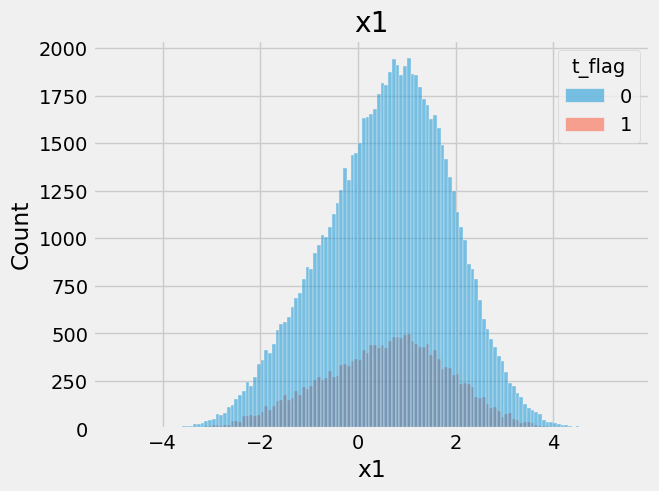

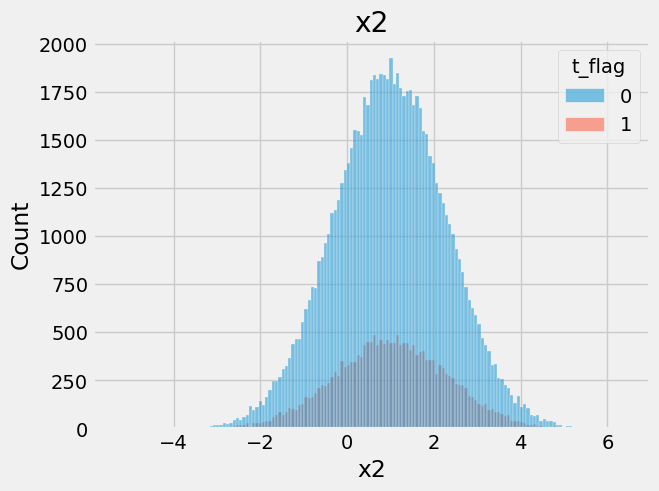

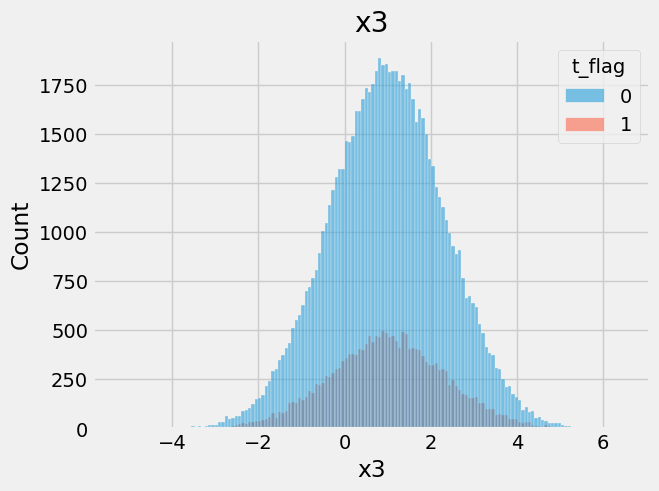

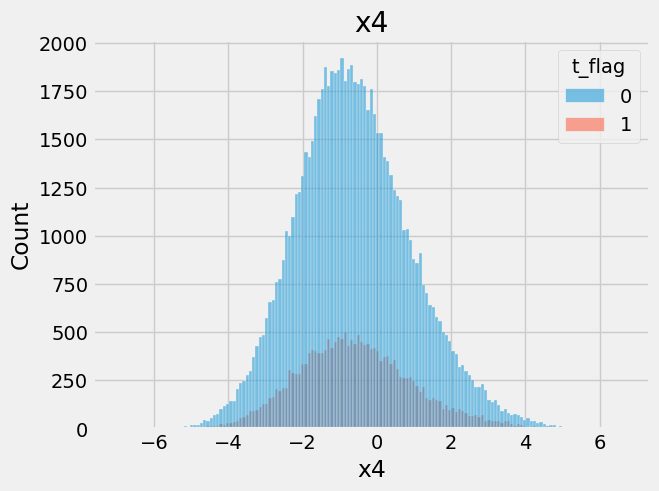

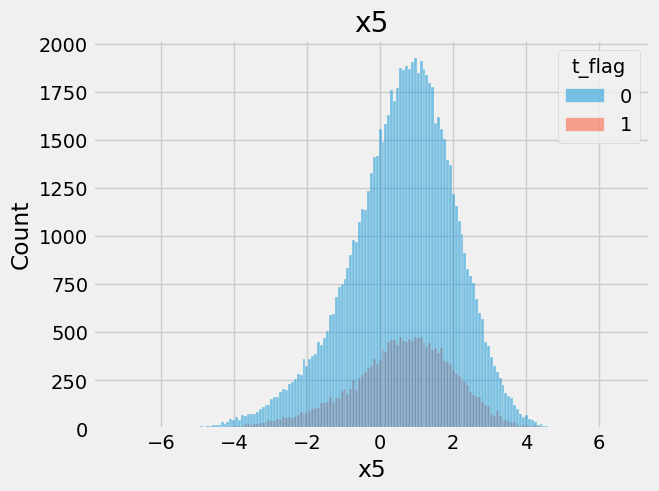

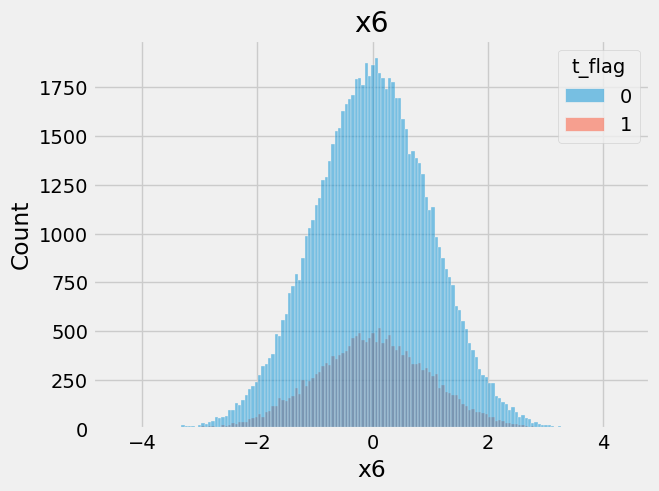

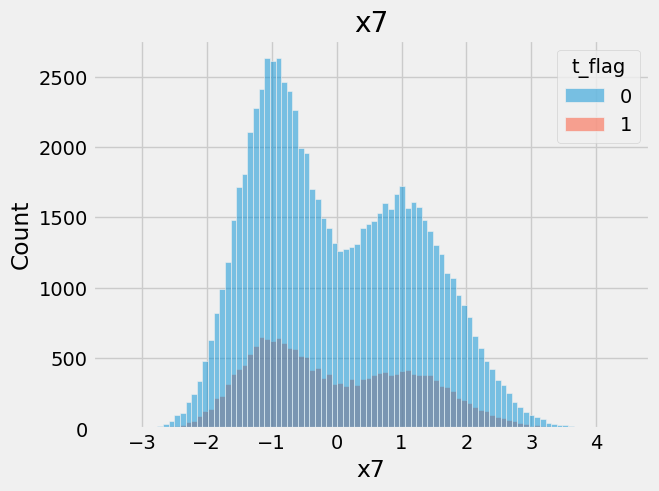

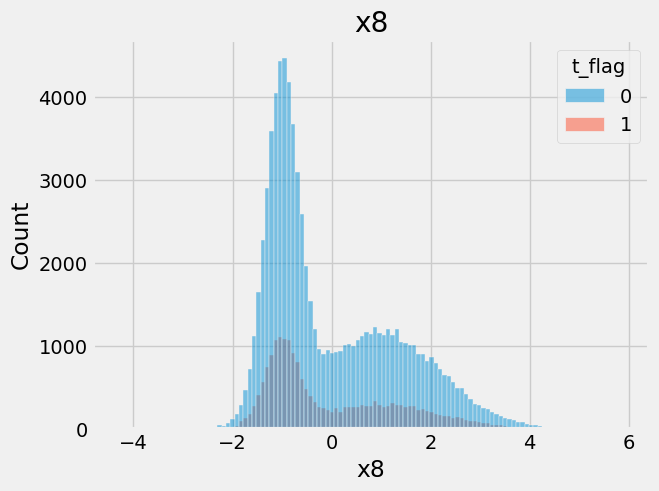

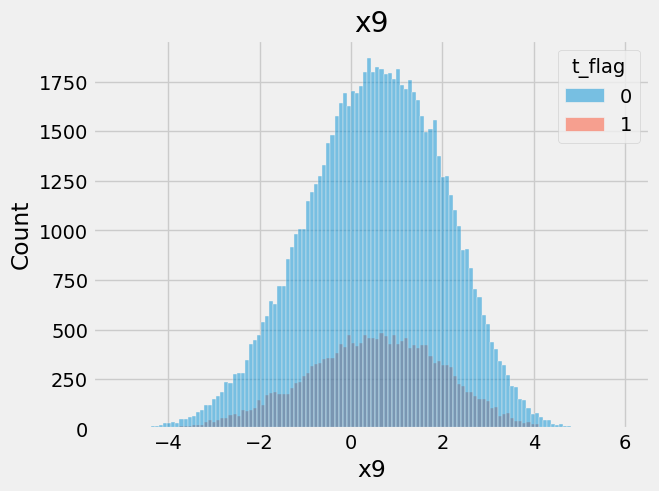

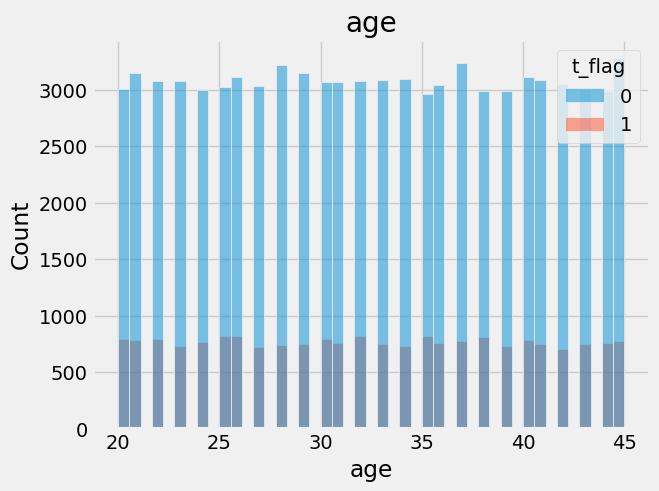

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification


for col in numeric_columns:
    sns.histplot(data = push, x=col, hue='t_flag').set_title(col)
    plt.show()

Таргет для **push** распределен неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.2 и 0.6).

Нет заметных расхождений средних и медиан для признаков. Поэтому попадание в контрольную и целевую группу не может зависеть от характеристик объекта.

Выши мы удалили клиентов, которые одновременно участвовали в двух компаниях. В результате получился дисболанс в количестве наблюдений контрольной и целевой группах (0: 80000, 1: 20000). При этом не появилось заметных расхождений средних и медиан для признаков.

Полагаю, что расхождение средних (0: 0.2 и 1: 0.6) для контрольной и целевой групп  указывает на то, что рекламное воздействие, вероятно, имеет эффект.


Сильный дисбаланс между контрольной и целевой группами может быть опасен для обучения uplift моделей, так как может привести к смещению модели, нестабильным оценкам и ухудшению обобщающей способности.
Далее будем использовать мтратификацию при разделении данных на обучающую, валидационную и тестовую выборки, чтобы сохранить пропорции между группами в каждой выборке. Это поможет убедиться, что модель получает достаточно данных для обучения для каждой группы.

In [215]:
push.head(2)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city,t_flag,target
0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,39,Ufa,0,0
6,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,33,Ufa,0,1


In [218]:
# создадим стратифицированную случайную подвыборку из контрольной группы, того же размера, что и целевая группа
# на основе полученных данных создадим обучающую выборку для push

X = push[push['t_flag'] == 0]
y = X['target']
del X['target']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, stratify=y)

In [222]:
X_train['target'] = y_train
X_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city,t_flag,target
277269,0.771257,0.483728,1.242929,0.847897,0.018726,-0.320809,-0.874262,0.886913,1.359988,37,Moscow,0,0
247159,-1.224293,1.713353,1.839730,-0.162026,-1.990460,-1.609025,-1.653829,2.088306,0.250555,29,Ufa,0,1
282292,-1.257127,2.228007,3.901262,-0.015293,1.157420,-0.540466,2.395339,-0.552255,-2.985370,33,Moscow,0,0
336607,0.089859,3.161047,0.990513,-1.010818,1.309546,1.485370,-0.328684,-1.480557,0.338129,25,Smolensk,0,0
203094,1.344747,-2.268933,2.080092,1.869204,-0.159480,-0.493362,-0.811163,0.893792,1.806307,27,Ufa,0,0


In [224]:
X_train.shape

(20000, 13)

In [226]:
push = pd.concat([X_train, push[push['t_flag'] == 1]], ignore_index=True)

In [228]:
push.shape

(40000, 13)

In [230]:
push.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city,t_flag,target
0,0.771257,0.483728,1.242929,0.847897,0.018726,-0.320809,-0.874262,0.886913,1.359988,37,Moscow,0,0
1,-1.224293,1.713353,1.839730,-0.162026,-1.990460,-1.609025,-1.653829,2.088306,0.250555,29,Ufa,0,1
2,-1.257127,2.228007,3.901262,-0.015293,1.157420,-0.540466,2.395339,-0.552255,-2.985370,33,Moscow,0,0
3,0.089859,3.161047,0.990513,-1.010818,1.309546,1.485370,-0.328684,-1.480557,0.338129,25,Smolensk,0,0
4,1.344747,-2.268933,2.080092,1.869204,-0.159480,-0.493362,-0.811163,0.893792,1.806307,27,Ufa,0,0


In [232]:
push['t_flag'].value_counts()

t_flag
0    20000
1    20000
Name: count, dtype: int64

In [234]:
push.select_dtypes(include=np.number).groupby(by='t_flag').mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,0.604423,0.991786,0.985908,-0.599976,0.586149,-0.006294,-0.004994,0.001480,0.527027,32.57240,0.20215
1,0.567231,1.013764,0.999262,-0.569823,0.578837,0.000178,-0.010200,-0.001318,0.498965,32.41535,0.60855


In [236]:
push.select_dtypes(include=np.number).groupby(by='t_flag').median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,0.686392,0.994151,0.983799,-0.697405,0.700394,-0.001075,-0.210083,-0.560383,0.573757,33.0,0.0
1,0.653599,1.010234,0.993041,-0.659436,0.698363,-0.001471,-0.215969,-0.560481,0.549919,32.0,1.0


In [238]:
push.groupby(by='t_flag')['city'].value_counts()

t_flag  city    
0       Ufa         6747
        Moscow      6693
        Smolensk    6560
1       Ufa         6794
        Moscow      6750
        Smolensk    6456
Name: count, dtype: int64

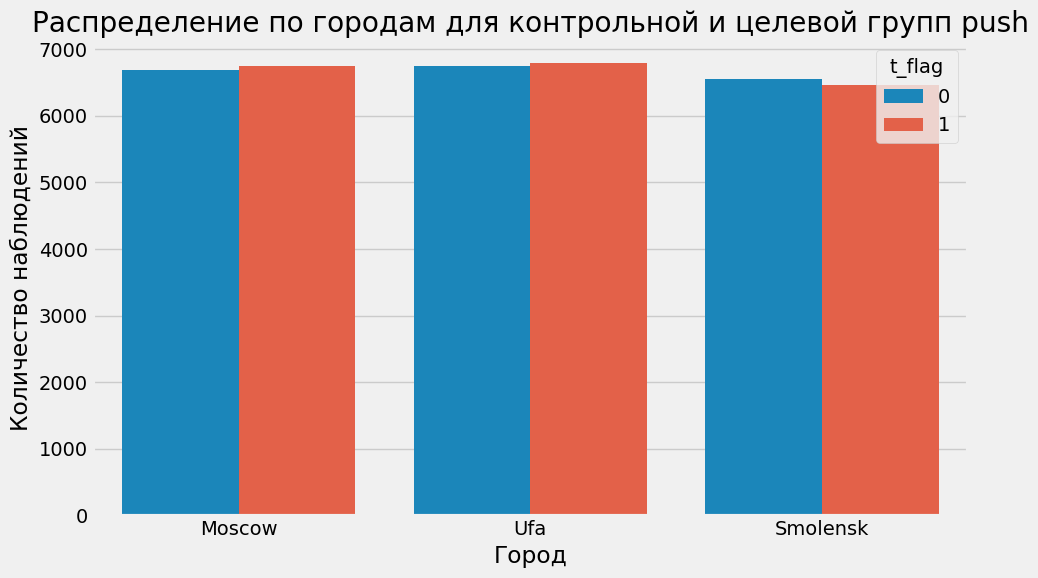

In [240]:
plt.figure(figsize=(10, 6))
sns.countplot(x='city', hue='t_flag', data=push)
plt.title('Распределение по городам для контрольной и целевой групп push')
plt.xlabel('Город')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=0)
plt.legend(title='t_flag', labels=['0', '1'])
plt.tight_layout()
plt.show()

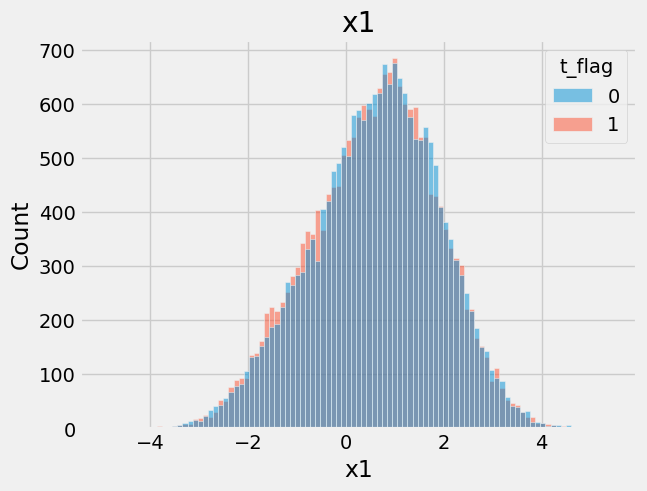

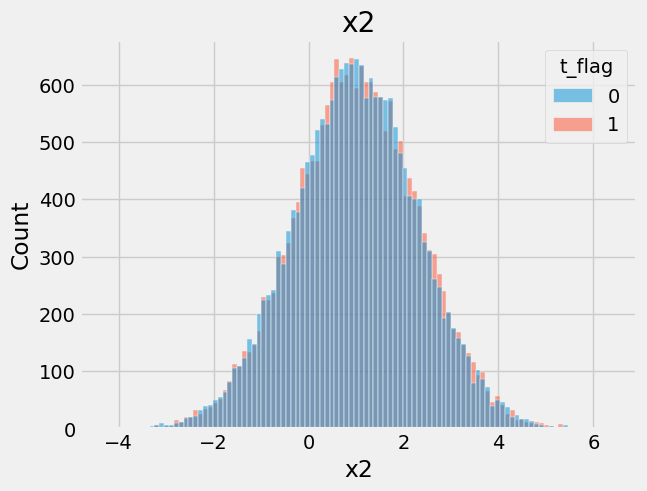

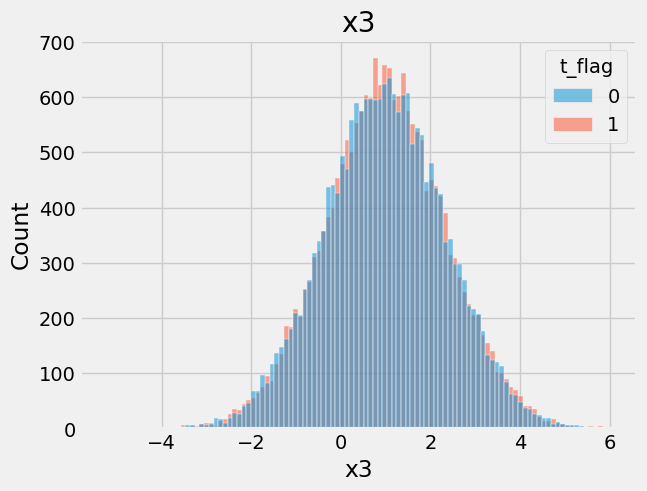

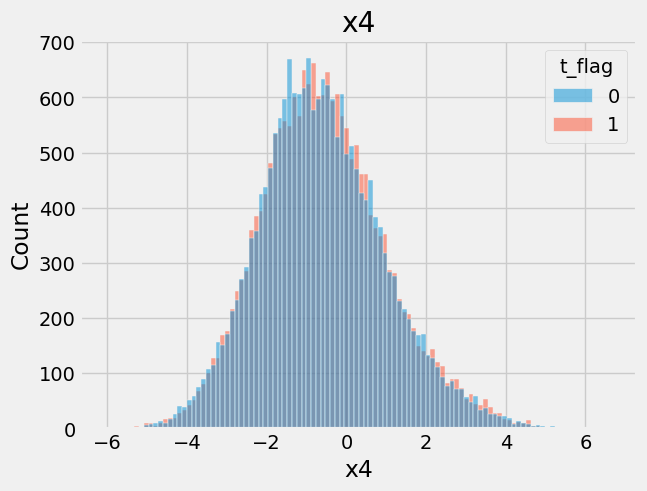

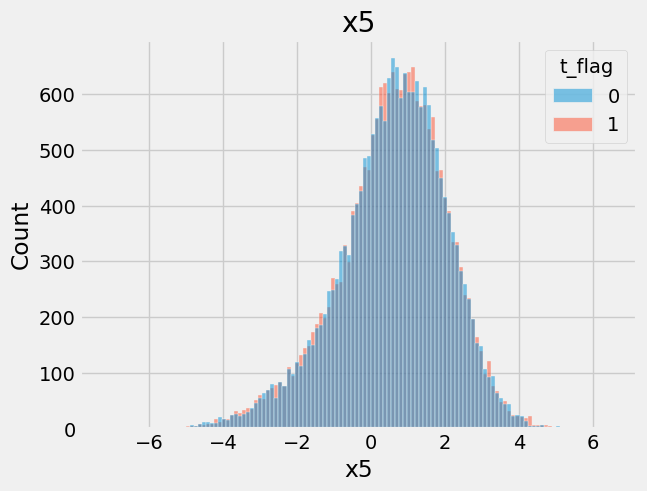

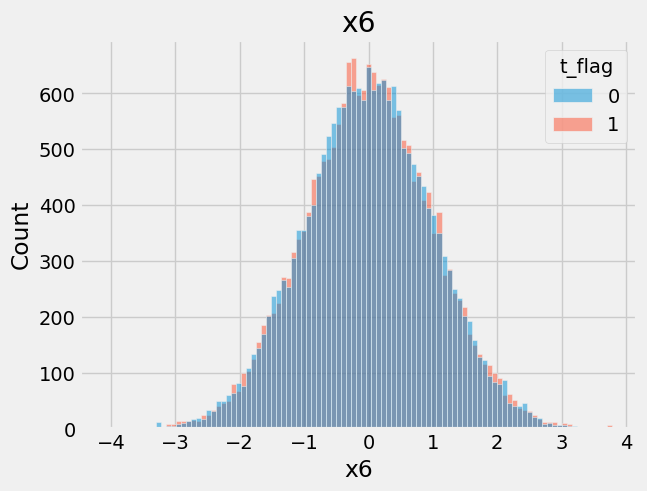

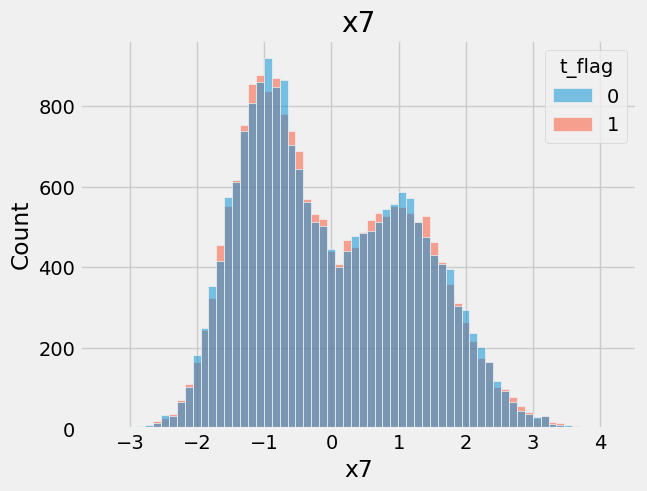

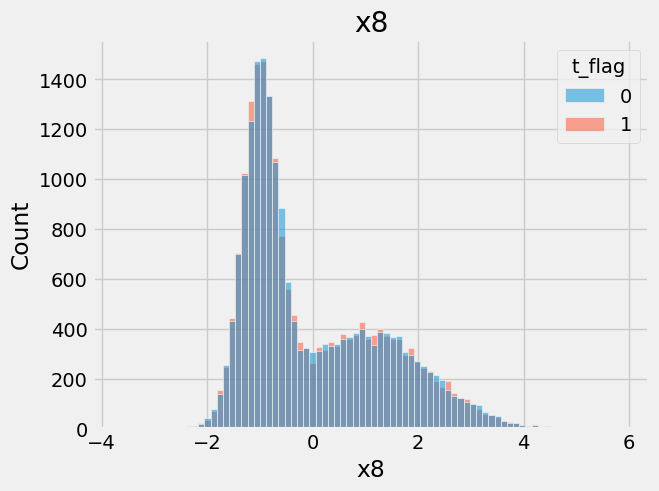

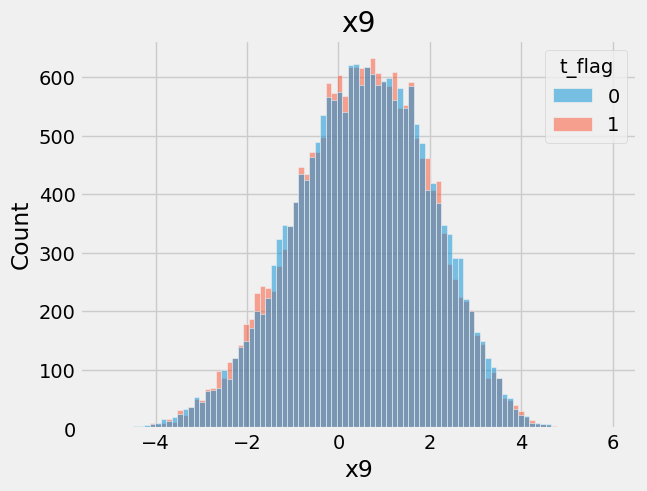

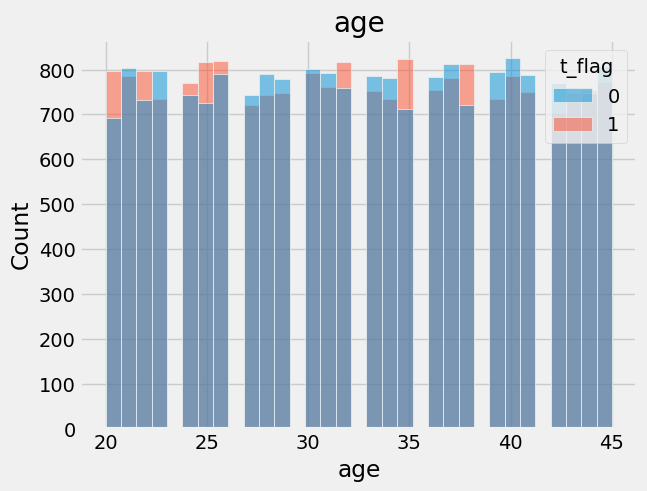

In [242]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification


for col in numeric_columns:
    sns.histplot(data = push, x=col, hue='t_flag').set_title(col)
    plt.show()

Таргет для **push** распределён неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.2 и 0.6).

Нет заметных расхождений средних и медиан для признаков. Поэтому попадание в контрольную и целевую группу не может зависеть от характеристик объекта.

C помощью случайного стратифицированного сэмлирования мы избавились от дисбаланса в количестве наблюдений между контрольной и целевой группами.

Полагаю, что расхождение средних (0: 0.2 и 1: 0.6) для контрольной и целевой групп указывает на то, что рекламное воздействие, вероятно, имеет эффект.

Сломанные данные push мы починили и подготовили к моделированию uplift.

**banner**

In [246]:
banner['t_flag'].value_counts()

t_flag
0    60000
1    60000
Name: count, dtype: int64

In [248]:
banner.select_dtypes(include=np.number).groupby(by='t_flag').mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,-0.200788,-1.005438,0.195224,-0.201540,0.005851,-0.000878,0.335597,0.333879,-0.231895,32.531317,0.400733
1,-0.190153,-0.996064,0.201646,-0.199495,-0.003222,0.002184,0.335707,0.332511,-0.234196,32.500350,0.602717


In [250]:
banner.select_dtypes(include=np.number).groupby(by='t_flag').median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,-0.039344,-1.000710,0.15114,-0.191527,0.004826,0.001446,0.520809,0.712336,-0.245529,33.0,0.0
1,-0.029260,-0.992088,0.16389,-0.182136,-0.004370,0.006098,0.513940,0.719739,-0.246031,33.0,1.0


In [252]:
banner.groupby(by='t_flag')['city'].value_counts()

t_flag  city    
0       Smolensk    20036
        Ufa         20010
        Moscow      19954
1       Ufa         20125
        Smolensk    20017
        Moscow      19858
Name: count, dtype: int64

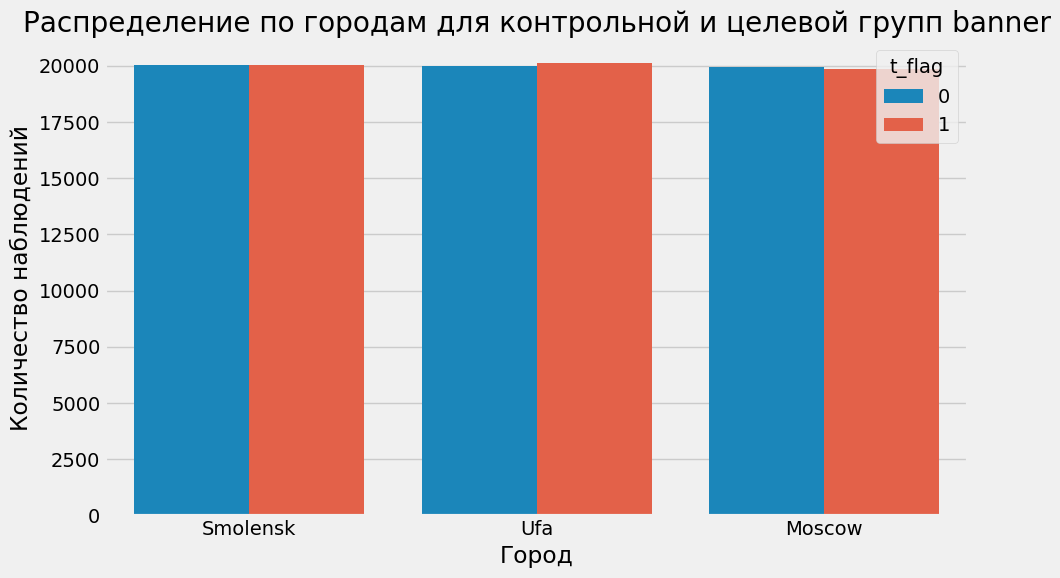

In [254]:
plt.figure(figsize=(10, 6))
sns.countplot(x='city', hue='t_flag', data=banner)
plt.title('Распределение по городам для контрольной и целевой групп banner')
plt.xlabel('Город')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=0)
plt.legend(title='t_flag', labels=['0', '1'])
plt.tight_layout()
plt.show()

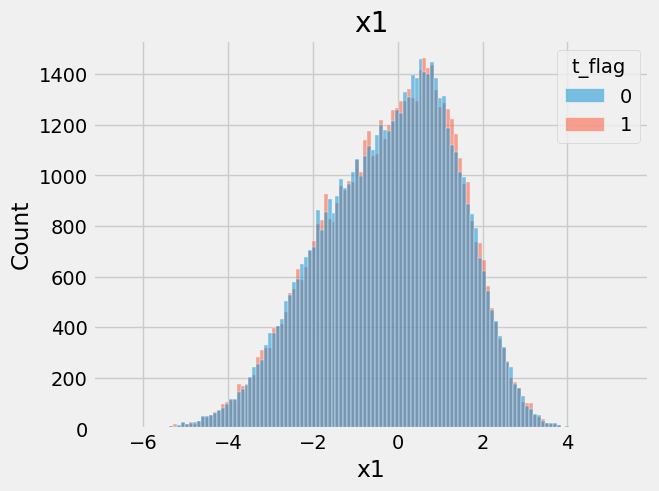

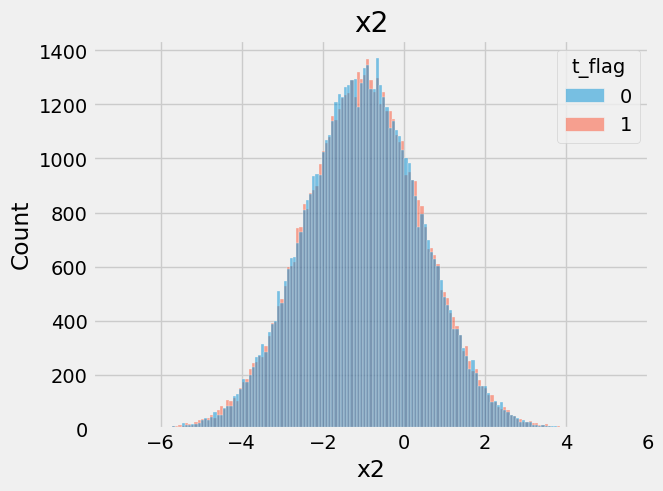

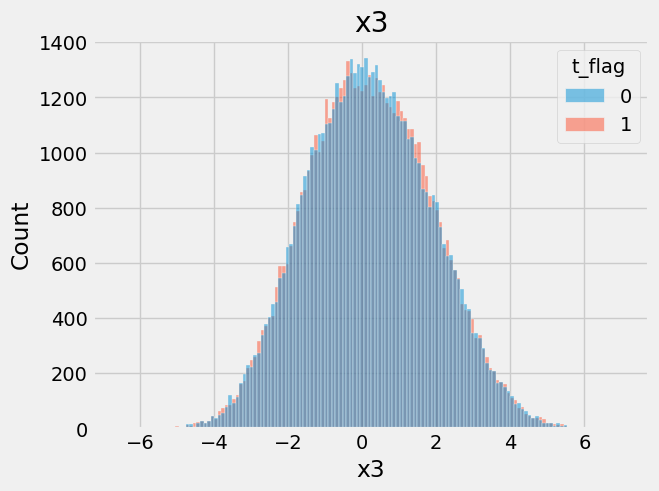

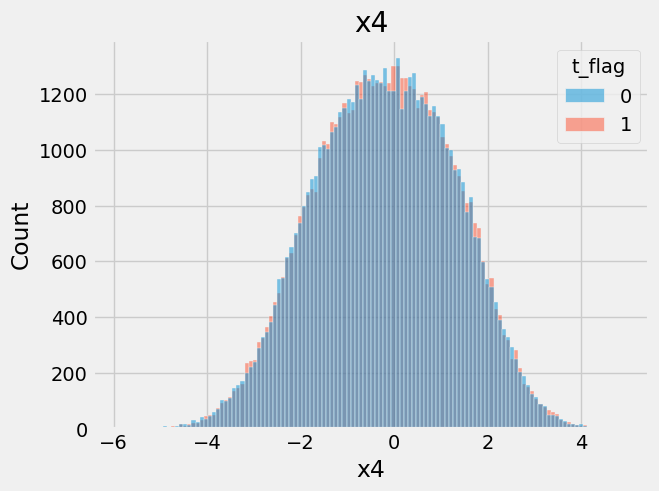

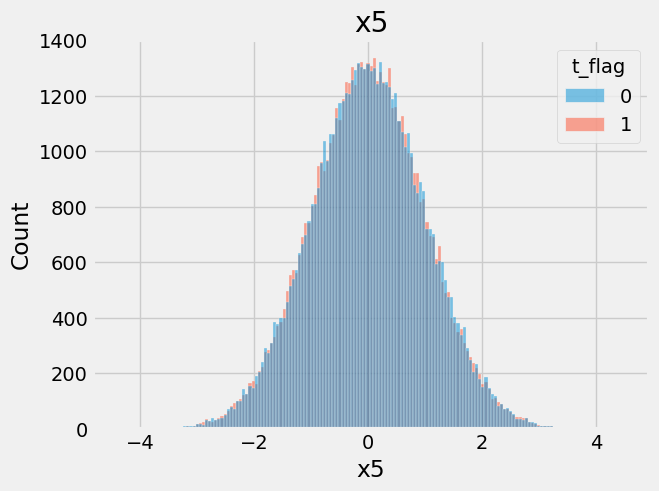

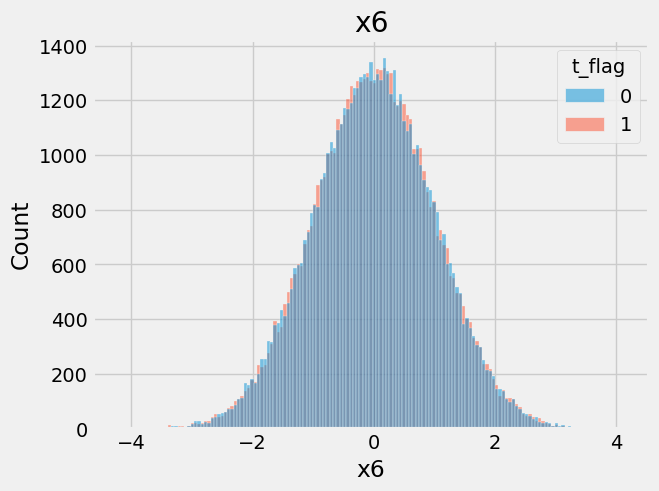

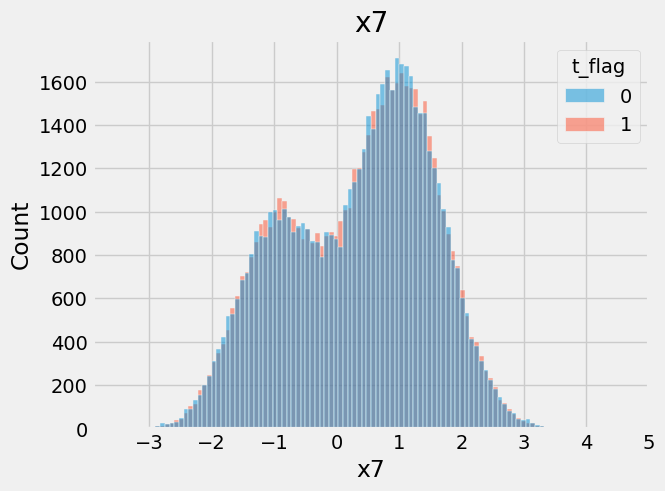

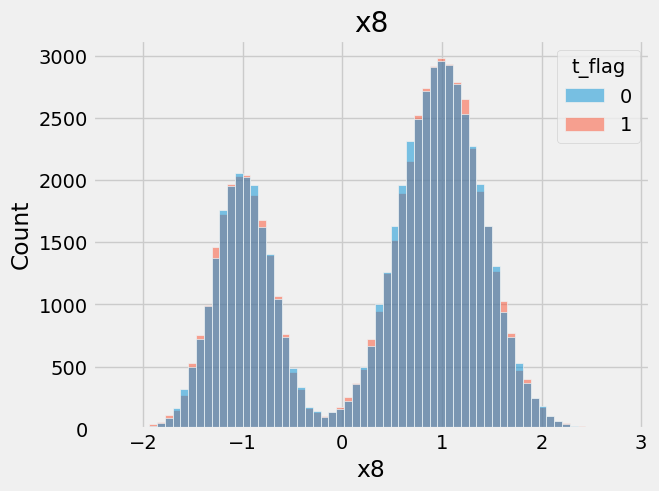

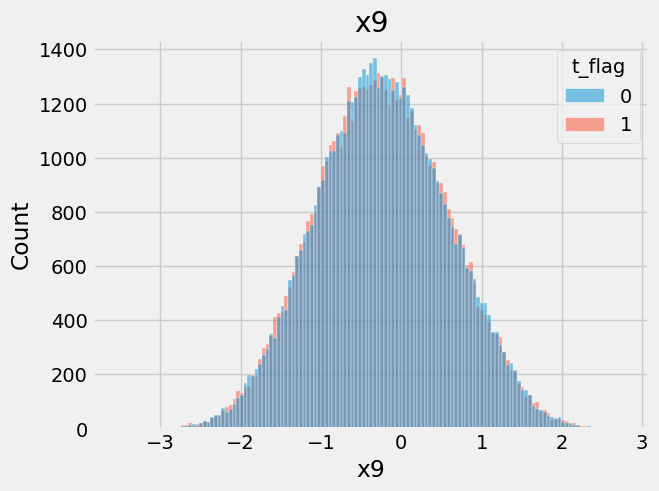

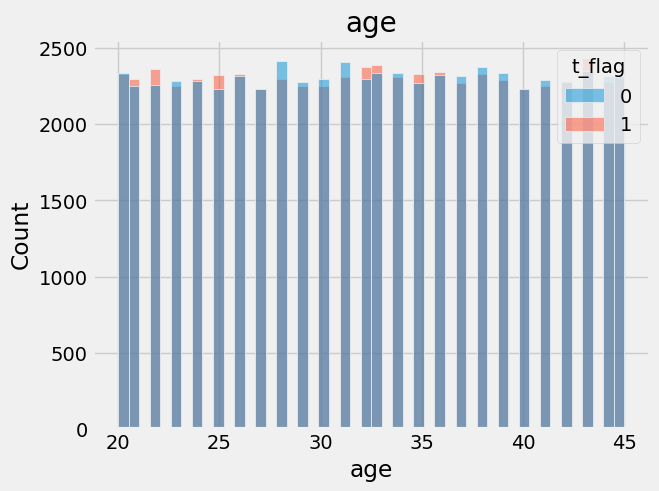

In [256]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification


for col in numeric_columns:
    sns.histplot(data = banner, x=col, hue='t_flag').set_title(col)
    plt.show()

Таргет для **banner** распределён неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.4 и 0.6).

Нет заметных расхождений средних и медиан для признаков. Поэтому попадание в контрольную и целевую группу не может зависеть от характеристик объекта.

Полагаю, что расхождение средних (0: 0.4 и 1: 0.6) для контрольной и целевой групп указывает на то, что рекламное воздействие, вероятно, имеет эффект.

**other_ads**

In [260]:
other_ads['t_flag'].value_counts()

t_flag
1    60000
0    60000
Name: count, dtype: int64

In [262]:
other_ads.select_dtypes(include=np.number).groupby(by='t_flag').mean()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,-0.200788,-1.005438,0.195224,-0.201540,0.000000,-0.000878,0.335597,0.333879,-0.231895,32.56505,0.400733
1,-0.190153,-0.996064,0.201646,-0.199495,-0.003222,0.002184,0.335707,0.332511,-0.234196,32.49420,0.602717


In [264]:
other_ads.select_dtypes(include=np.number).groupby(by='t_flag').median()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,target
t_flag,,,,,,,,,,,
0,-0.039344,-1.000710,0.15114,-0.191527,0.00000,0.001446,0.520809,0.712336,-0.245529,33.0,0.0
1,-0.029260,-0.992088,0.16389,-0.182136,-0.00437,0.006098,0.513940,0.719739,-0.246031,32.0,1.0


In [266]:
other_ads.groupby(by='t_flag')['city'].value_counts()

t_flag  city    
0       Smolensk    36056
        Moscow      12033
        Ufa         11911
1       Ufa         20175
        Smolensk    20006
        Moscow      19819
Name: count, dtype: int64

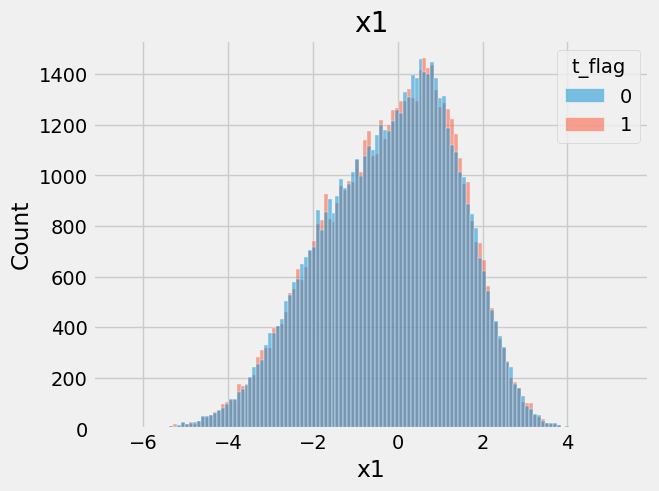

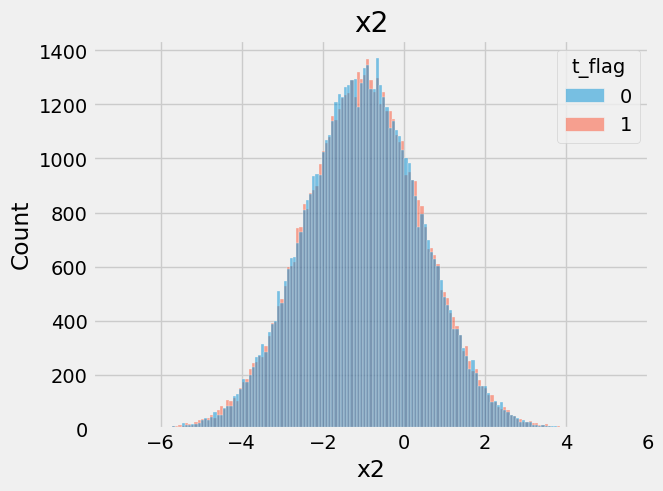

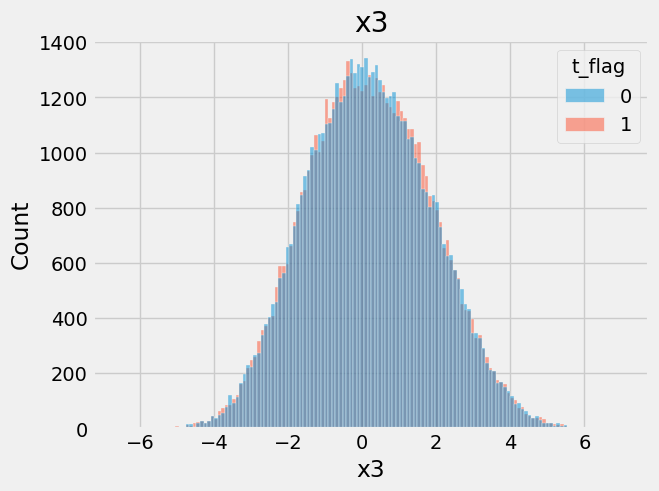

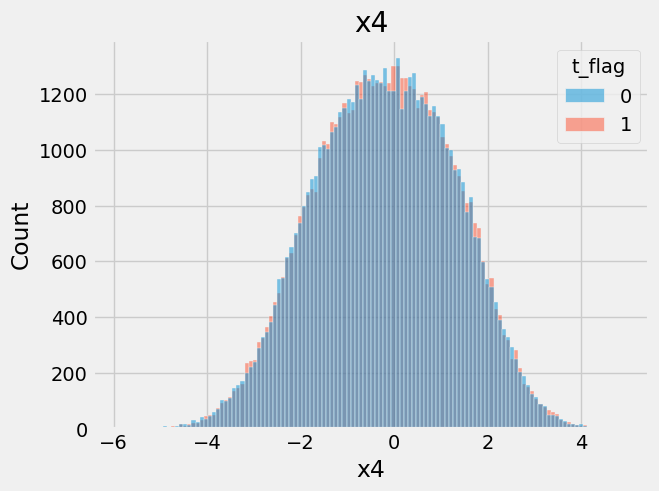

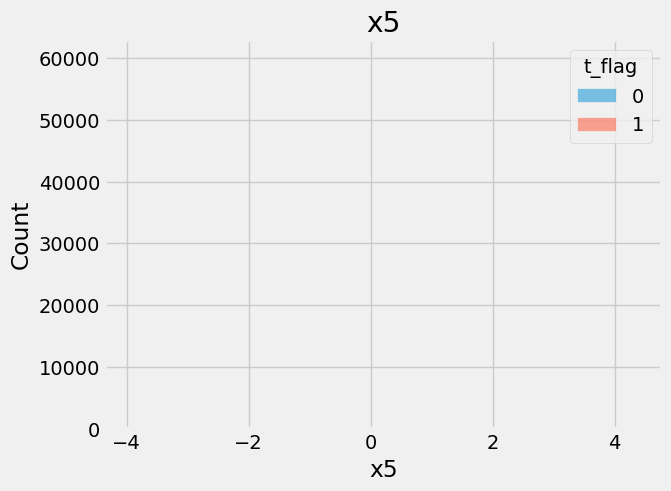

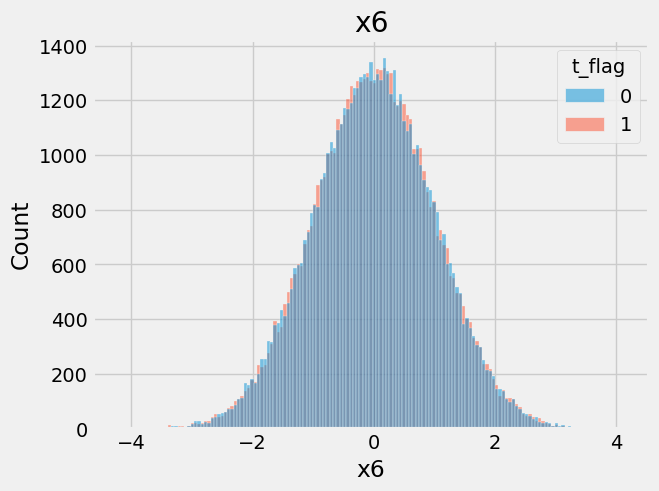

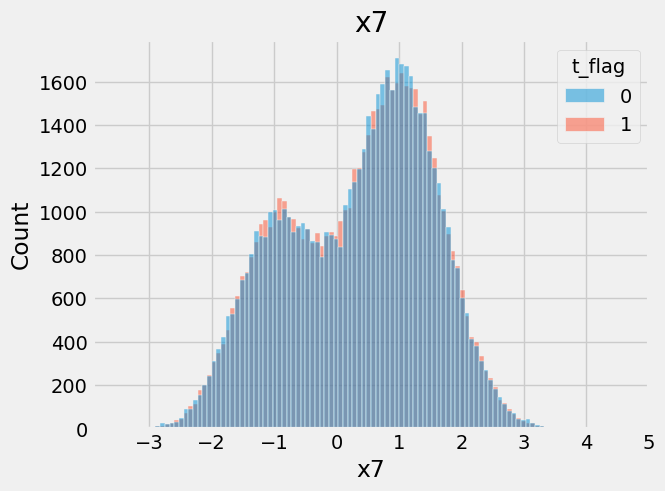

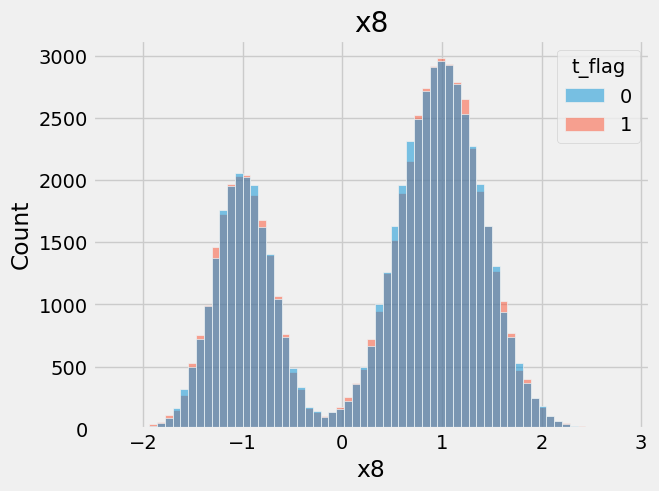

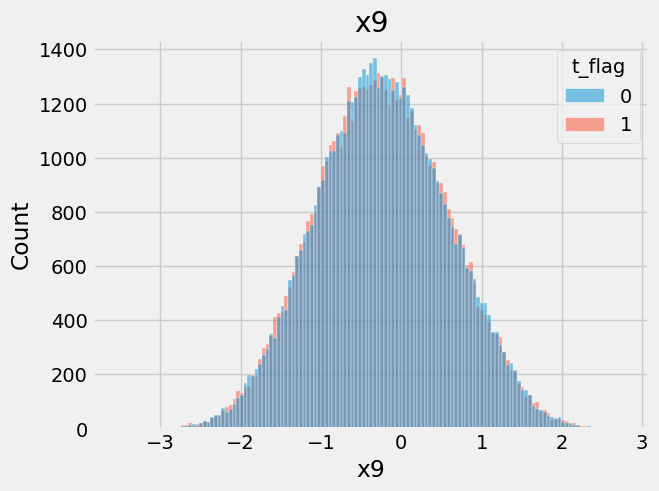

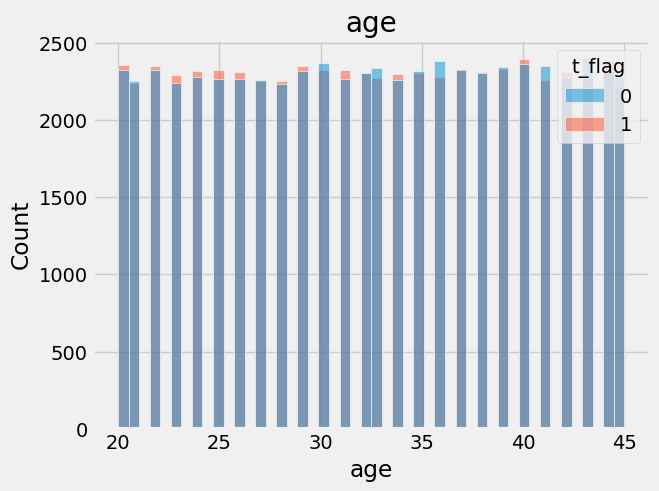

In [268]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification


for col in numeric_columns:
    sns.histplot(data = other_ads, x=col, hue='t_flag').set_title(col)
    plt.show()

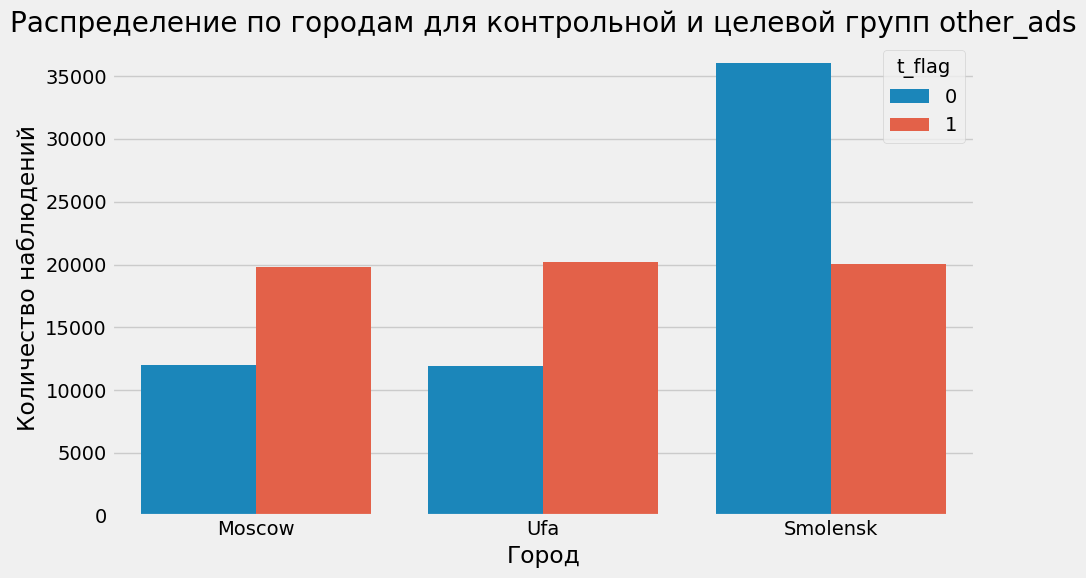

In [270]:
plt.figure(figsize=(10, 6))
sns.countplot(x='city', hue='t_flag', data=other_ads)
plt.title('Распределение по городам для контрольной и целевой групп other_ads')
plt.xlabel('Город')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=0)
plt.legend(title='t_flag', labels=['0', '1'])
plt.tight_layout()
plt.show()

Таргет для **other_ads** распределён неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.4 и 0.6).

Нет заметных расхождений средних и медиан для числовых признаков.
Но есть заметные расхождения распределения категориального признака city.
Поэтому попадание в контрольную и целевую группу может зависеть от характеристик объекта (от города клиента).

**other_ads** представляют собой сломанные данные. Мы не будем их использовать далее.
Чтобы починить данные можно было бы сделать случайное стратифицированное сэмлирование по таргету для каждого города так, чтобы города были одинаково представлены в контрольной и целевой группе, а проаорция значений target для городов сохранилась.

### ваши выводы здесь

Таргет для **push** распределен неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.2 и 0.6).
Полагаю, что расхождение средних (0: 0.2 и 1: 0.6) для контрольной и целевой групп указывает на то, что рекламное воздействие push, вероятно, имеет эффект.

Нет заметных расхождений средних и медиан для признаков. Поэтому попадание в контрольную и целевую группу не может зависеть от характеристик объекта.

Выше мы удалили клиентов, которые одновременно участвовали в двух компаниях. В результате получился дисбаланс в количестве наблюдений в контрольной и в целевой группах (0: 80000, 1: 20000). При этом не появилось заметных расхождений средних и медиан для признаков.

Сильный дисбаланс между контрольной и целевой группами может быть опасен для обучения uplift моделей, так как может привести к смещению модели, нестабильным оценкам и ухудшению обобщающей способности. 
Поэтому мы модифицировали данные с помощью случайного стратифицированного сэмлирования. C помощью случайного стратифицированного сэмлирования мы избавились от дисбаланса в количестве наблюдений между контрольной и целевой группами. Мы избавились от дисбаланса в количестве наблюдений между контрольной и целевой группами.
Сломанные данные push мы починили и подготовили к моделированию uplift.


Таргет для **banner** распределён неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.4 и 0.6).
Полагаю, что расхождение средних (0: 0.4 и 1: 0.6) для контрольной и целевой групп указывает на то, что рекламное воздействие, вероятно, имеет эффект.
Нет заметных расхождений средних и медиан для признаков. Поэтому попадание в контрольную и целевую группу не может зависеть от характеристик объекта.


Таргет для **other_ads** распределён неравномерно между контрольной и целевой группой, присутствует заметное расхождение средних (0.4 и 0.6).

Нет заметных расхождений средних и медиан для числовых признаков. Но есть заметные расхождения распределения категориального признака city. Поэтому попадание в контрольную и целевую группу может зависеть от характеристик объекта (от города клиента).
other_ads представляют собой сломанные данные. Мы не будем их использовать далее. Чтобы починить данные можно было бы сделать случайное стратифицированное сэмлирование по таргету для каждого города так, чтобы города были одинаково представлены в контрольной и целевой группе, а пропорция значений target для городов сохранилась.

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [273]:
# ваш код здесь
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification

In [275]:
# push   banner 
# создадим столбец strat для стратификации тестовой и тренировочной выборок по столбцам t_flag и target 

In [277]:
push['strat'] = push[['t_flag', 'target']].apply(lambda x: str(x['t_flag']) + str(x['target']), axis = 1)

In [279]:
banner['strat'] = banner[['t_flag', 'target']].apply(lambda x: str(x['t_flag']) + str(x['target']), axis = 1)

In [281]:
push_train, push_test = train_test_split(push, test_size=0.25, stratify=push['strat'])

In [283]:
del push_train['strat']
del push_test['strat']

In [285]:
banner_train, banner_test = train_test_split(banner, test_size=0.25, stratify=banner['strat'])

In [287]:
del banner_train['strat']
del banner_test['strat']

In [289]:
# теперь закодируем категориальный признак city с помощью OHE. Учиться будем на трэйне. трансформируем трэйн и тест

In [291]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct_push = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['city'])],
    remainder='passthrough'
)


push_train_encoded = pd.DataFrame(ct_push.fit_transform(push_train),
                          columns=ct_push.get_feature_names_out(),
                          index=push_train.index)

In [293]:
push_test_encoded = pd.DataFrame(ct_push.transform(push_test),
                          columns=ct_push.get_feature_names_out(),
                          index=push_test.index)

In [317]:
ct_banner = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['city'])],
    remainder='passthrough'
)


banner_train_encoded = pd.DataFrame(ct_banner.fit_transform(banner_train),
                          columns=ct_banner.get_feature_names_out(),
                          index=banner_train.index)


banner_test_encoded = pd.DataFrame(ct_banner.transform(banner_test),
                          columns=ct_banner.get_feature_names_out(),
                          index=banner_test.index)

In [3]:
!/home/ivan/AIHW/six/.venv/bin/pip index versions causalml

causalml (0.15.3)
Available versions: 0.15.3, 0.15.2, 0.15.1, 0.15.0, 0.14.1, 0.14.0, 0.13.0, 0.12.3, 0.12.2, 0.12.1, 0.12.0, 0.11.1, 0.11.0, 0.10.0, 0.9.0, 0.8.0, 0.7.1, 0.7.0, 0.6.0, 0.5.0, 0.4.0, 0.3.0, 0.2.3, 0.2.2, 0.2.1, 0.2.0
  INSTALLED: 0.15.1
  LATEST:    0.15.3

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: /home/ivan/AIHW/six/.venv/bin/python -m pip install --upgrade pip


In [15]:
import sys
print(sys.executable)

/home/ivan/AIHW/six/.venv/bin/python


In [1]:
!/home/ivan/AIHW/six/.venv/bin/pip index versions scikit-learn

scikit-learn (1.6.1)
Available versions: 1.6.1, 1.6.0, 1.5.2, 1.5.1, 1.5.0, 1.4.2, 1.4.1.post1, 1.4.0, 1.3.2, 1.3.1, 1.3.0, 1.2.2, 1.2.1, 1.2.0, 1.1.3, 1.1.2, 1.1.1, 1.1.0, 1.0.2, 1.0.1, 1.0, 0.24.2, 0.24.1, 0.24.0, 0.23.2, 0.23.1, 0.23.0, 0.22.2.post1, 0.22.1, 0.22, 0.21.3, 0.21.2, 0.21.1, 0.20.4, 0.20.3, 0.20.2, 0.20.1, 0.20.0, 0.19.2, 0.19.1, 0.19.0, 0.18.2, 0.18.1, 0.18, 0.17.1, 0.17, 0.16.1, 0.16.0, 0.15.2, 0.15.1, 0.15.0, 0.14.1, 0.14, 0.13.1, 0.13, 0.12.1, 0.12, 0.11, 0.10, 0.9
  INSTALLED: 1.3.2
  LATEST:    1.6.1

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: /home/ivan/AIHW/six/.venv/bin/python -m pip install --upgrade pip


In [319]:
import causalml
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier

In [321]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     StratifiedKFold)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV


import optuna

from catboost import CatBoostClassifier



In [323]:
from sklift.models import (SoloModel,
                           TwoModels,
                           ClassTransformation,
                           ClassTransformationReg)
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score,
                            make_uplift_scorer)


In [325]:
from sklift.viz import plot_qini_curve, plot_uplift_curve

#### **Solomodel**

In [328]:
model_LogReg_push = LogisticRegression()

model_LogReg_banner = LogisticRegression()

model_LogReg_push.fit(push_train_encoded.drop(columns = 'remainder__target'), push_train_encoded.remainder__target)

model_LogReg_banner.fit(banner_train_encoded.drop(columns = 'remainder__target'), banner_train_encoded.remainder__target)

LogisticRegression()

In [330]:
push_test_0 = push_test_encoded.drop(columns = 'remainder__target')
push_test_0['remainder__t_flag'] = 0
push_test_0.head()

,onehot__city_Moscow,onehot__city_Smolensk,onehot__city_Ufa,remainder__x1,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__age,remainder__t_flag
484,1.0,0.0,0.0,0.486907,1.658575,1.056962,0.176017,0.879708,1.071181,-0.713521,-0.219341,0.986580,31.0,0
1100,0.0,0.0,1.0,0.143882,1.336000,3.165317,0.867148,1.937470,-0.620622,1.472178,-0.713366,-1.041655,44.0,0
16039,0.0,1.0,0.0,-1.076456,1.279592,-0.210696,0.044678,0.585354,0.137514,-0.805586,4.022889,-0.293433,41.0,0
19109,0.0,0.0,1.0,-1.310125,2.207177,1.579974,1.379866,1.285884,1.578860,-0.620436,-0.290001,-0.642317,38.0,0
29069,0.0,1.0,0.0,1.762457,-0.604500,1.092376,-1.436434,1.465175,0.975440,1.047990,-1.099705,0.695085,36.0,0


In [332]:
push_test_1 = push_test_encoded.drop(columns = 'remainder__target')
push_test_1['remainder__t_flag'] = 1
push_test_1.head()

,onehot__city_Moscow,onehot__city_Smolensk,onehot__city_Ufa,remainder__x1,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__age,remainder__t_flag
484,1.0,0.0,0.0,0.486907,1.658575,1.056962,0.176017,0.879708,1.071181,-0.713521,-0.219341,0.986580,31.0,1
1100,0.0,0.0,1.0,0.143882,1.336000,3.165317,0.867148,1.937470,-0.620622,1.472178,-0.713366,-1.041655,44.0,1
16039,0.0,1.0,0.0,-1.076456,1.279592,-0.210696,0.044678,0.585354,0.137514,-0.805586,4.022889,-0.293433,41.0,1
19109,0.0,0.0,1.0,-1.310125,2.207177,1.579974,1.379866,1.285884,1.578860,-0.620436,-0.290001,-0.642317,38.0,1
29069,0.0,1.0,0.0,1.762457,-0.604500,1.092376,-1.436434,1.465175,0.975440,1.047990,-1.099705,0.695085,36.0,1


In [334]:
banner_test_0 = banner_test_encoded.drop(columns = 'remainder__target')
banner_test_0['remainder__t_flag'] = 0
banner_test_0.head()

,onehot__city_Moscow,onehot__city_Smolensk,onehot__city_Ufa,remainder__x1,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__age,remainder__t_flag
251788,0.0,0.0,1.0,2.062770,0.923160,-0.231807,2.553140,-0.704988,-1.223151,1.886454,1.587907,-0.838305,36.0,0
266678,0.0,1.0,0.0,1.986747,-0.349444,-0.456183,2.036453,-1.458185,-2.140815,0.328053,1.157523,-0.000225,23.0,0
179234,0.0,1.0,0.0,-3.612372,1.994012,4.459692,2.010773,-0.309186,0.673835,1.834841,1.794317,-2.455178,44.0,0
48764,1.0,0.0,0.0,-1.524695,0.548542,2.774352,0.421065,0.312003,-0.978920,1.782036,1.089174,-1.839571,28.0,0
99997,1.0,0.0,0.0,-0.174433,-1.943282,-1.570154,0.178503,-0.809464,1.877093,0.307719,0.572269,0.399576,23.0,0


In [336]:
banner_test_1 = banner_test_encoded.drop(columns = 'remainder__target')
banner_test_1['remainder__t_flag'] = 1
banner_test_1.head()

,onehot__city_Moscow,onehot__city_Smolensk,onehot__city_Ufa,remainder__x1,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__age,remainder__t_flag
251788,0.0,0.0,1.0,2.062770,0.923160,-0.231807,2.553140,-0.704988,-1.223151,1.886454,1.587907,-0.838305,36.0,1
266678,0.0,1.0,0.0,1.986747,-0.349444,-0.456183,2.036453,-1.458185,-2.140815,0.328053,1.157523,-0.000225,23.0,1
179234,0.0,1.0,0.0,-3.612372,1.994012,4.459692,2.010773,-0.309186,0.673835,1.834841,1.794317,-2.455178,44.0,1
48764,1.0,0.0,0.0,-1.524695,0.548542,2.774352,0.421065,0.312003,-0.978920,1.782036,1.089174,-1.839571,28.0,1
99997,1.0,0.0,0.0,-0.174433,-1.943282,-1.570154,0.178503,-0.809464,1.877093,0.307719,0.572269,0.399576,23.0,1


In [338]:
LogReg_push_pred_0 = model_LogReg_push.predict_proba(push_test_0)[:,1]

LogReg_push_pred_1 = model_LogReg_push.predict_proba(push_test_1)[:,1]

LogReg_banner_pred_0 = model_LogReg_banner.predict_proba(banner_test_0)[:,1]

LogReg_banner_pred_1 = model_LogReg_banner.predict_proba(banner_test_1)[:,1]

uplift_LogReg_push = LogReg_push_pred_1 - LogReg_push_pred_0

uplift_LogReg_banner = LogReg_banner_pred_1 - LogReg_banner_pred_0

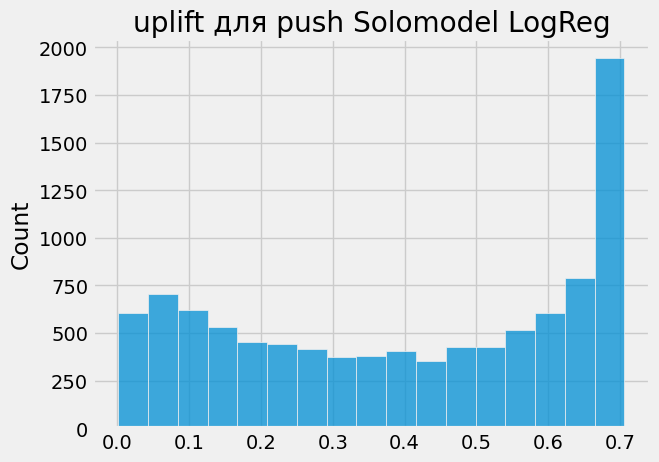

In [340]:
uplift_pd = pd.DataFrame(data = uplift_LogReg_push, index = push_test_encoded.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_LogReg_push).set_title('uplift для push Solomodel LogReg')
plt.show()

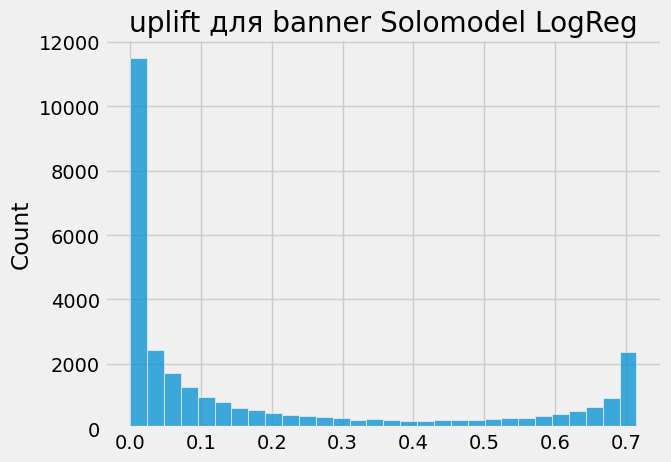

In [342]:
uplift_pd = pd.DataFrame(data = uplift_LogReg_banner, index = banner_test_encoded.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_LogReg_banner).set_title('uplift для banner Solomodel LogReg')
plt.show()

**push** метрики

In [408]:
uplift_at_k(y_true=push_test_encoded.remainder__target,
            uplift=uplift_LogReg_push,
            treatment=push_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.64

In [410]:
uplift_auc_score(y_true=push_test_encoded.remainder__target,
                 uplift=uplift_LogReg_push,
                 treatment=push_test_encoded['remainder__t_flag'])

0.2907931988636747

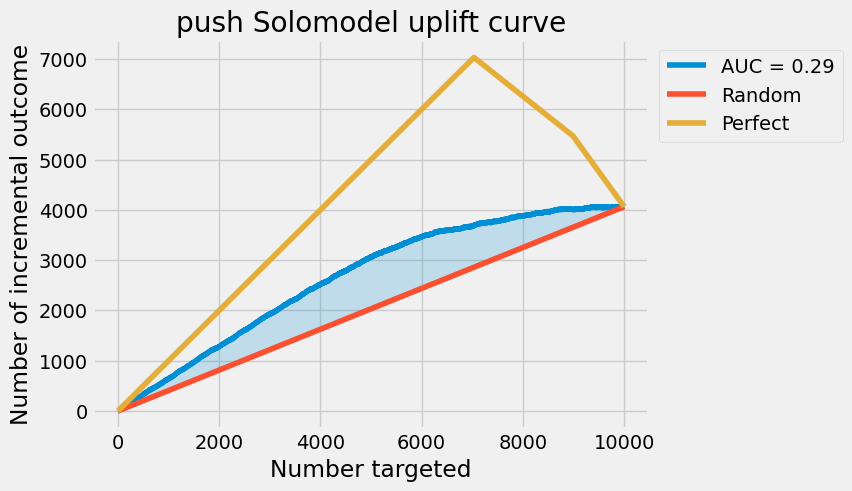

In [412]:
plot_uplift_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_LogReg_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Solomodel uplift curve')
plt.show()

In [414]:
qini_auc_score(y_true=push_test_encoded.remainder__target,
               uplift=pd.Series(uplift_LogReg_push, index=push_test_encoded.index),
               treatment=push_test_encoded['remainder__t_flag'])

0.19896154150961629

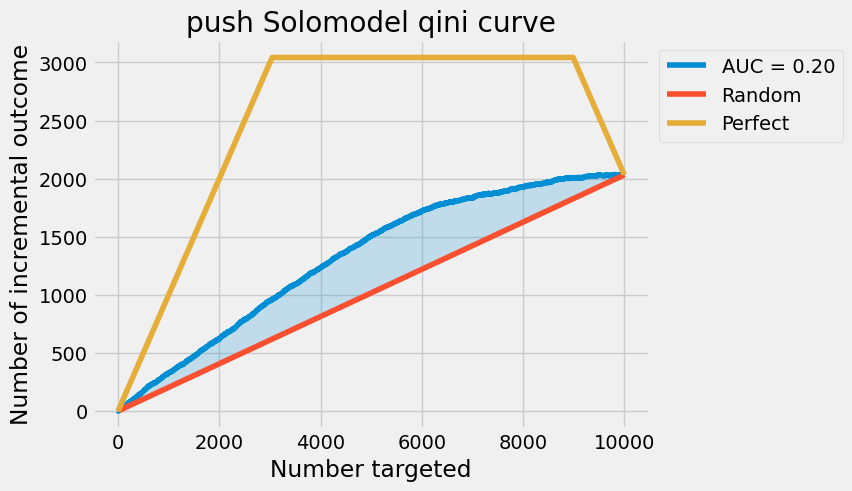

In [416]:
plot_qini_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_LogReg_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Solomodel qini curve')
plt.show()

**banner** метрики

In [419]:
uplift_at_k(y_true=banner_test_encoded.remainder__target,
            uplift=uplift_LogReg_banner,
            treatment=banner_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.8333333333333333

In [421]:
uplift_auc_score(y_true=banner_test_encoded.remainder__target,
                 uplift=uplift_LogReg_banner,
                 treatment=banner_test_encoded['remainder__t_flag'])

0.2962799901877087

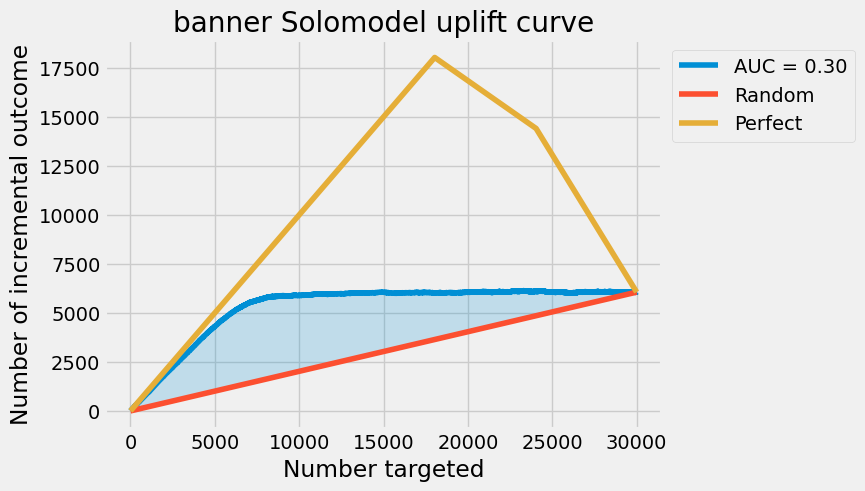

In [423]:
plot_uplift_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_LogReg_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Solomodel uplift curve')
plt.show()

In [425]:
qini_auc_score(y_true=banner_test_encoded.remainder__target,
               uplift=pd.Series(uplift_LogReg_banner, index=banner_test_encoded.index),
               treatment=banner_test_encoded['remainder__t_flag'])

0.20362879270614287

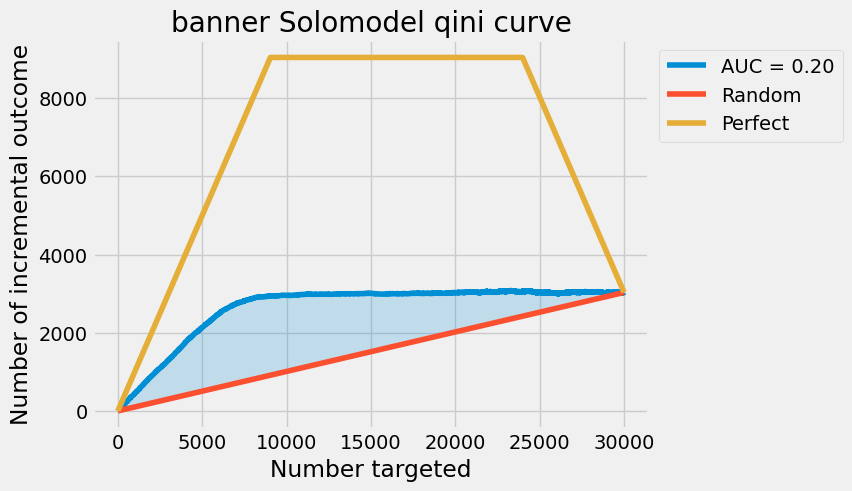

In [427]:
plot_qini_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_LogReg_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Solomodel qini curve')
plt.show()

#### **Solomodel из библиотеки Sklift**

In [344]:
sm_push = SoloModel(estimator=LogisticRegression())

sm_banner = SoloModel(estimator=LogisticRegression())


sm_push.fit(push_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
       push_train_encoded.remainder__target,
       treatment=push_train_encoded['remainder__t_flag'])

sm_banner.fit(banner_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
       banner_train_encoded.remainder__target,
       treatment=banner_train_encoded['remainder__t_flag'])

SoloModel(estimator=LogisticRegression())

In [346]:
uplift_sm_push = sm_push.predict(push_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

uplift_sm_banner = sm_banner.predict(banner_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))


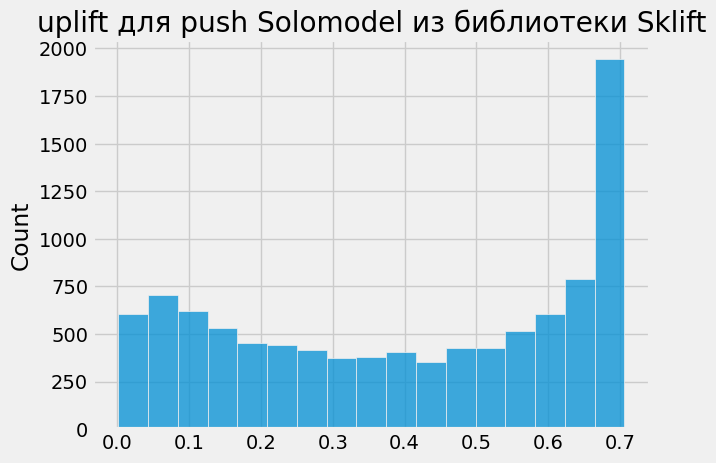

In [348]:
uplift_pd = pd.DataFrame(data = uplift_sm_push, index = push_test_encoded.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_sm_push).set_title('uplift для push Solomodel из библиотеки Sklift')
plt.show()

Идеальная гистограмма uplift обычно смещена вправо (положительная асимметрия). Это означает, что большинство пользователей имеют небольшой или отрицательный uplift, а небольшое количество пользователей имеет очень высокий положительный uplift. Это именно то, что вы хотите видеть: модель выявляет небольшую группу людей, на которых стоит нацелиться.

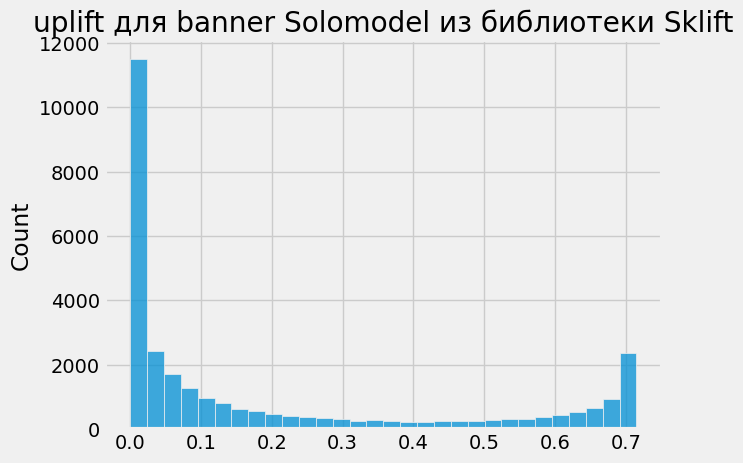

In [351]:
uplift_pd = pd.DataFrame(data = uplift_sm_banner, index = banner_test_encoded.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_sm_banner).set_title('uplift для banner Solomodel из библиотеки Sklift')
plt.show()

In [355]:
np.linalg.norm(uplift_LogReg_push - uplift_sm_push) / np.linalg.norm(uplift_sm_push)

0.0

In [357]:
np.linalg.norm(uplift_LogReg_banner - uplift_sm_banner) / np.linalg.norm(uplift_sm_banner)

0.0

Мы получили идентичные результаты, как с наивным подходом, так и с помощью Solomodel из sklift. Посмотрим, какое получилось качество Uplift

uplift_at_k показывает, насколько больше конверсий (или целевых действий) вы получите, воздействуя на k процентов пользователей, которых модель определила как наиболее восприимчивых к воздействию, по сравнению с тем, если бы вы воздействовали на случайно выбранных k процентов пользователей. Более высокое значение uplift_at_k означает, что модель лучше выявляет пользователей, на которых стоит воздействовать.

**push** метрики

In [357]:
uplift_at_k(y_true=push_test_encoded.remainder__target,
            uplift=uplift_sm_push,
            treatment=push_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.64

In [359]:
uplift_auc_score(y_true=push_test_encoded.remainder__target,
                 uplift=uplift_sm_push,
                 treatment=push_test_encoded['remainder__t_flag'])

0.2907931988636747

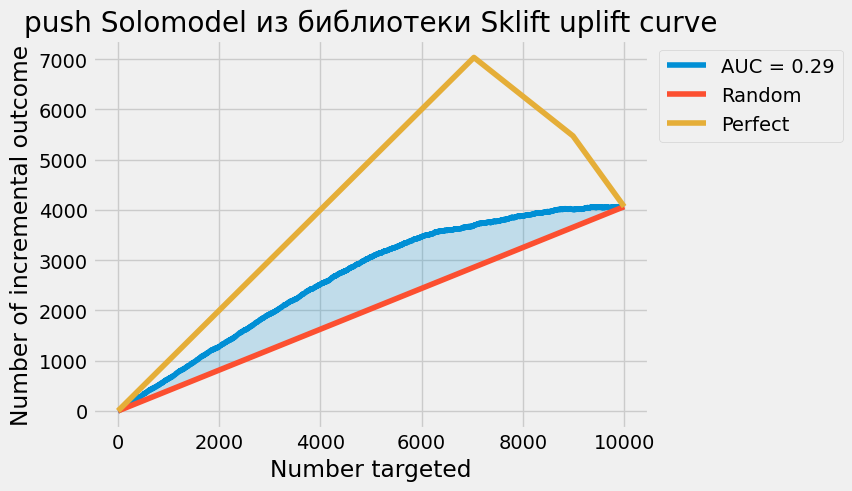

In [383]:
plot_uplift_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_sm_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Solomodel из библиотеки Sklift uplift curve')
plt.show()

In [388]:
qini_auc_score(y_true=push_test_encoded.remainder__target,
               uplift=pd.Series(uplift_sm_push, index=push_test_encoded.index),
               treatment=push_test_encoded['remainder__t_flag'])

0.19896154150961629

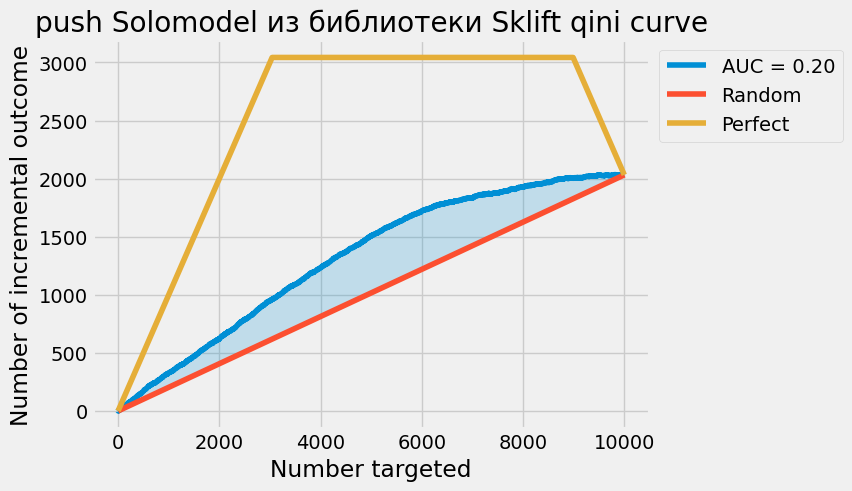

In [394]:
plot_qini_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_sm_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Solomodel из библиотеки Sklift qini curve')
plt.show()

**banner** метрики

In [361]:
uplift_at_k(y_true=banner_test_encoded.remainder__target,
            uplift=uplift_sm_banner,
            treatment=banner_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.8333333333333333

In [363]:
uplift_auc_score(y_true=banner_test_encoded.remainder__target,
                 uplift=uplift_sm_banner,
                 treatment=banner_test_encoded['remainder__t_flag'])

0.2962799901877087

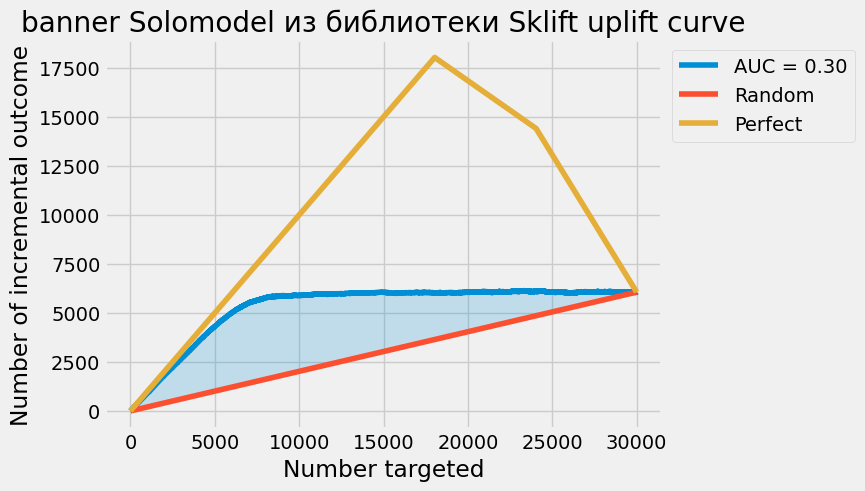

In [385]:
plot_uplift_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_sm_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Solomodel из библиотеки Sklift uplift curve')
plt.show()

In [397]:
qini_auc_score(y_true=banner_test_encoded.remainder__target,
               uplift=pd.Series(uplift_sm_banner, index=banner_test_encoded.index),
               treatment=banner_test_encoded['remainder__t_flag'])

0.20362879270614287

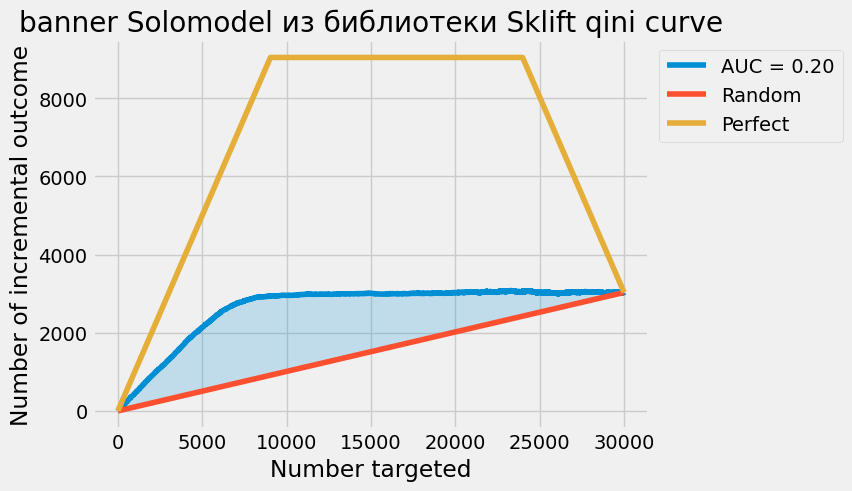

In [399]:
plot_qini_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_sm_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Solomodel из библиотеки Sklift qini curve')
plt.show()

#### Metalearners: Twomodels pipeline

**push**

In [379]:
RANDOM_STATE = 42

In [381]:
model_1_push = LogisticRegression(random_state=RANDOM_STATE+1)
model_2_push = LogisticRegression(random_state=RANDOM_STATE+2)

In [383]:
#независимые модели
tm_ind_push = TwoModels(estimator_trmnt=model_1_push,
                   estimator_ctrl=model_2_push,
                   method='vanilla')

In [385]:
pipe_push = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', tm_ind_push)
])

In [387]:
pipe_push.fit(push_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
         push_train_encoded.remainder__target,
         model_uplift__treatment=push_train_encoded.drop(columns = 'remainder__target')['remainder__t_flag'])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model_uplift',
                 TwoModels(estimator_ctrl=LogisticRegression(random_state=44),
                           estimator_trmnt=LogisticRegression(random_state=43)))])

In [389]:
uplift_metalearners_push = pipe_push.predict(push_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

**push** метрики

In [394]:
uplift_at_k(y_true=push_test_encoded.remainder__target,
            uplift=uplift_metalearners_push,
            treatment=push_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.991

In [398]:
uplift_auc_score(y_true=push_test_encoded.remainder__target,
                 uplift=uplift_metalearners_push,
                 treatment=push_test_encoded['remainder__t_flag'])

0.5349110198209696

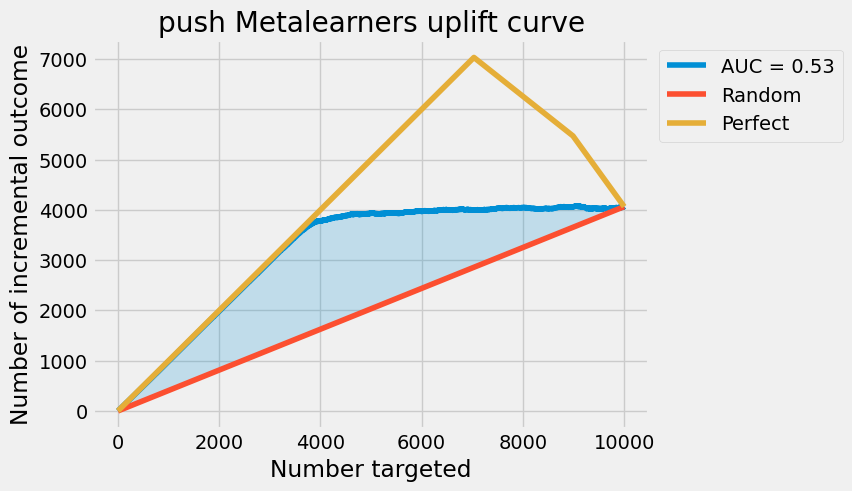

In [400]:
plot_uplift_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_metalearners_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Metalearners uplift curve')
plt.show()

In [404]:
qini_auc_score(y_true=push_test_encoded.remainder__target,
               uplift=pd.Series(uplift_metalearners_push, index=push_test_encoded.index),
               treatment=push_test_encoded['remainder__t_flag'])

0.3848974023581239

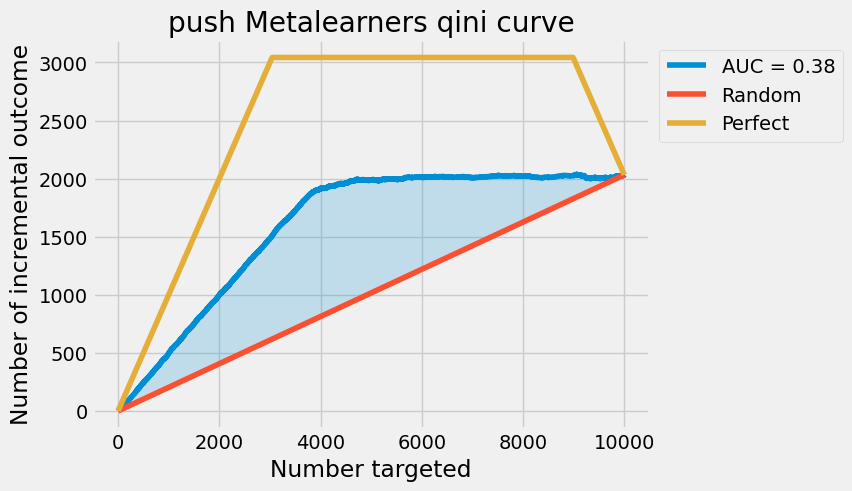

In [406]:
plot_qini_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_metalearners_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Metalearners qini curve')
plt.show()

**banner**

In [409]:
model_1_banner = LogisticRegression(random_state=RANDOM_STATE+1)
model_2_banner = LogisticRegression(random_state=RANDOM_STATE+2)


#независимые модели
tm_ind_banner = TwoModels(estimator_trmnt=model_1_banner,
                   estimator_ctrl=model_2_banner,
                   method='vanilla')




pipe_banner = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', tm_ind_banner)
])


pipe_banner.fit(banner_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
         banner_train_encoded.remainder__target,
         model_uplift__treatment=banner_train_encoded.drop(columns = 'remainder__target')['remainder__t_flag'])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model_uplift',
                 TwoModels(estimator_ctrl=LogisticRegression(random_state=44),
                           estimator_trmnt=LogisticRegression(random_state=43)))])

In [411]:
uplift_metalearners_banner = pipe_banner.predict(banner_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

**banner** метрики

In [416]:
uplift_at_k(y_true=banner_test_encoded.remainder__target,
            uplift=uplift_metalearners_banner,
            treatment=banner_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.9630000000000001

In [418]:
uplift_auc_score(y_true=banner_test_encoded.remainder__target,
                 uplift=uplift_metalearners_banner,
                 treatment=banner_test_encoded['remainder__t_flag'])

0.3092978799514211

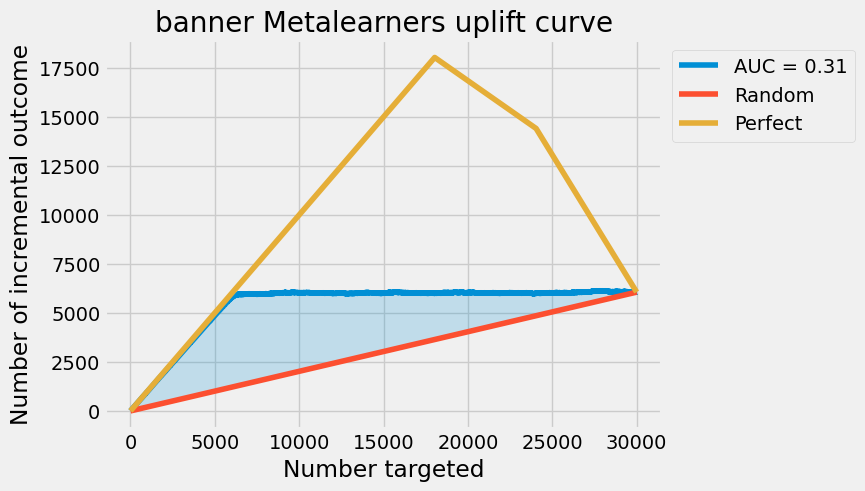

In [420]:
plot_uplift_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_metalearners_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Metalearners uplift curve')
plt.show()

In [426]:
qini_auc_score(y_true=banner_test_encoded.remainder__target,
               uplift=pd.Series(uplift_metalearners_banner, index=banner_test_encoded.index),
               treatment=banner_test_encoded['remainder__t_flag'])

0.21093180947360654

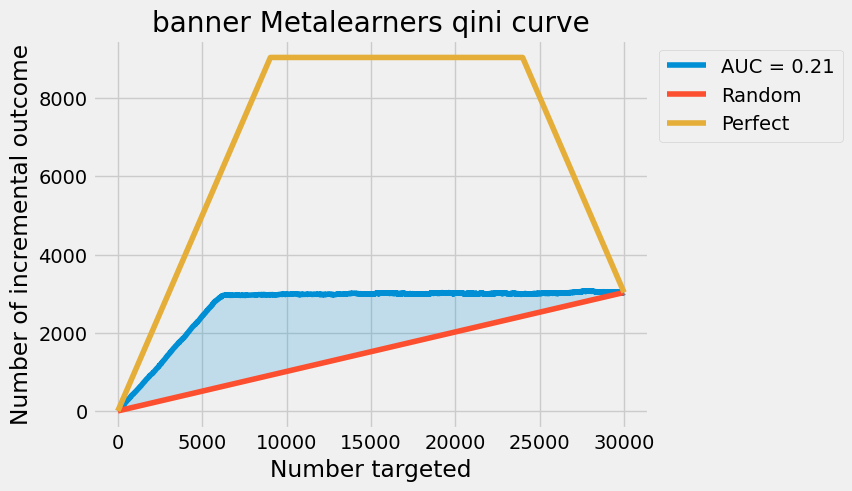

In [428]:
plot_qini_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_metalearners_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Metalearners qini curve')
plt.show()


#### Metalearners: CatBoostClassifier и калибровка 

In [432]:
skf_push = StratifiedKFold(n_splits=5,
                      random_state=RANDOM_STATE,
                      shuffle=True)

In [434]:
model_1_cb_push = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE, thread_count=-1)
model_2_cb_push = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE+1, thread_count=-1)

calib_model_1_push = CalibratedClassifierCV(estimator=model_1_cb_push, method='isotonic', cv=skf_push)
calib_model_2_push = CalibratedClassifierCV(estimator=model_2_cb_push, method='isotonic', cv=skf_push)

In [436]:
tm_catboost_push = TwoModels(estimator_trmnt=calib_model_1_push,
                        estimator_ctrl=calib_model_2_push)

In [438]:
tm_catboost_push.fit(push_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
                push_train_encoded.remainder__target,
                treatment=push_train_encoded['remainder__t_flag'])

TwoModels(estimator_ctrl=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                estimator=<catboost.core.CatBoostClassifier object at 0x7f5c490fc370>,
                                                method='isotonic'),
          estimator_trmnt=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                 estimator=<catboost.core.CatBoostClassifier object at 0x7f5c4905f250>,
                                                 method='isotonic'))

In [440]:
uplift_catboost_push = tm_catboost_push.predict(push_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

**push** метрики

In [445]:
uplift_at_k(y_true=push_test_encoded.remainder__target,
            uplift=uplift_catboost_push,
            treatment=push_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.992

In [447]:
uplift_auc_score(y_true=push_test_encoded.remainder__target,
                 uplift=uplift_catboost_push,
                 treatment=push_test_encoded['remainder__t_flag'])

0.542054650474891

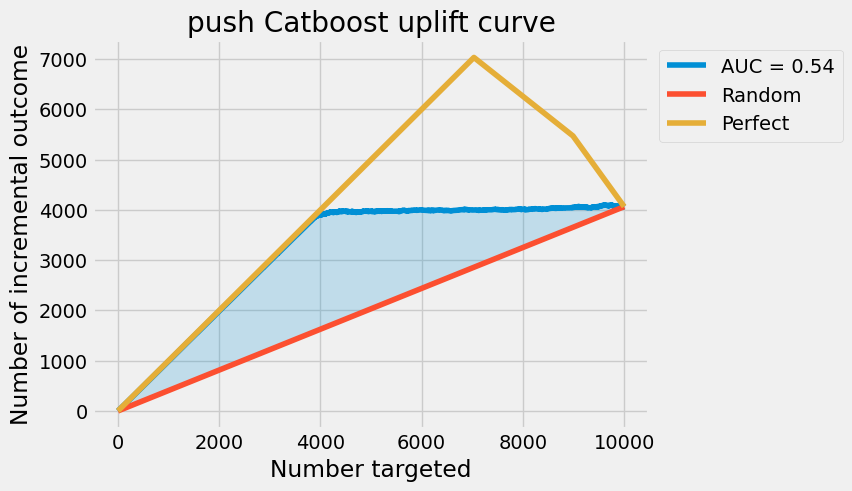

In [449]:
plot_uplift_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_catboost_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Catboost uplift curve')
plt.show()

In [453]:
qini_auc_score(y_true=push_test_encoded.remainder__target,
               uplift=pd.Series(uplift_catboost_push, index=push_test_encoded.index),
               treatment=push_test_encoded['remainder__t_flag'])

0.38756065193067857

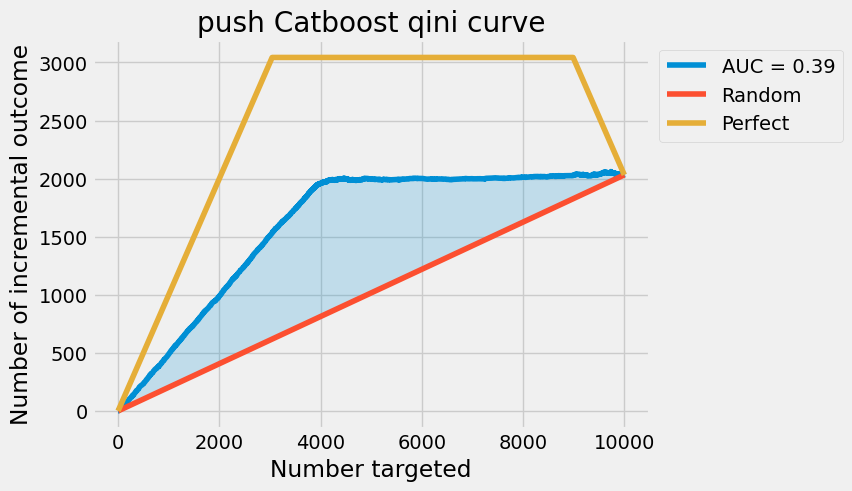

In [455]:
plot_qini_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_catboost_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Catboost qini curve')
plt.show()

**banner**

In [458]:
skf_banner = StratifiedKFold(n_splits=5,
                      random_state=RANDOM_STATE,
                      shuffle=True)


model_1_cb_banner = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE, thread_count=-1)
model_2_cb_banner = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE+1, thread_count=-1)

calib_model_1_banner = CalibratedClassifierCV(estimator=model_1_cb_banner, method='isotonic', cv=skf_banner)
calib_model_2_banner = CalibratedClassifierCV(estimator=model_2_cb_banner, method='isotonic', cv=skf_banner)


tm_catboost_banner = TwoModels(estimator_trmnt=calib_model_1_banner,
                        estimator_ctrl=calib_model_2_banner)


tm_catboost_banner.fit(banner_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
                banner_train_encoded.remainder__target,
                treatment=banner_train_encoded['remainder__t_flag'])





TwoModels(estimator_ctrl=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                estimator=<catboost.core.CatBoostClassifier object at 0x7f5c4938ff10>,
                                                method='isotonic'),
          estimator_trmnt=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                 estimator=<catboost.core.CatBoostClassifier object at 0x7f5c48de07c0>,
                                                 method='isotonic'))

In [460]:
uplift_catboost_banner = tm_catboost_banner.predict(banner_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

**banner** метрики

In [465]:
uplift_at_k(y_true=banner_test_encoded.remainder__target,
            uplift=uplift_catboost_banner,
            treatment=banner_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.9716666666666667

In [469]:
uplift_auc_score(y_true=banner_test_encoded.remainder__target,
                 uplift=uplift_catboost_banner,
                 treatment=banner_test_encoded['remainder__t_flag'])

0.30886869033596986

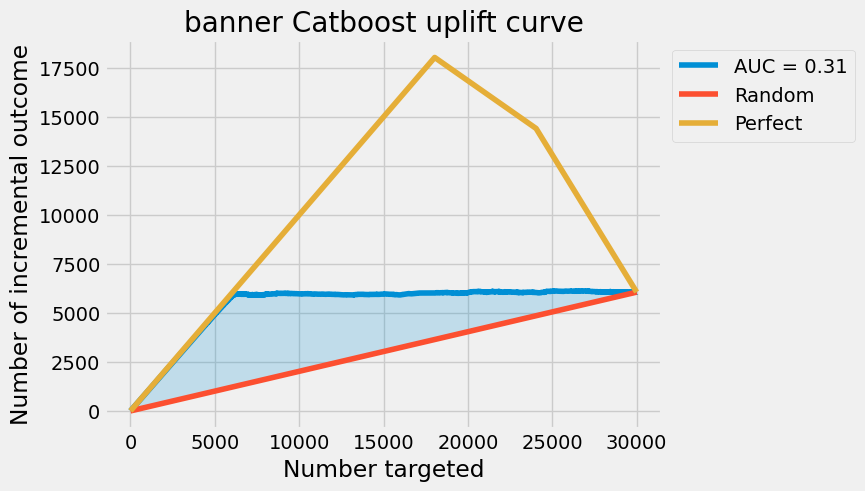

In [471]:
plot_uplift_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_catboost_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Catboost uplift curve')
plt.show()

In [473]:
qini_auc_score(y_true=banner_test_encoded.remainder__target,
               uplift=pd.Series(uplift_catboost_banner, index=banner_test_encoded.index),
               treatment=banner_test_encoded['remainder__t_flag'])

0.2127422097583749

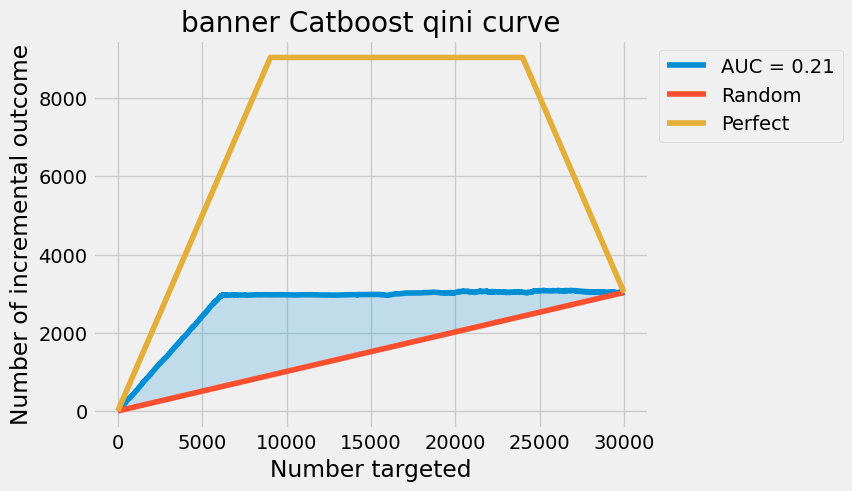

In [475]:
plot_qini_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_catboost_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Catboost qini curve')
plt.show()

#### ClassTransformation

In [477]:
ct_push = ClassTransformation(model_1_cb_push)
# fit the model
ct_push = ct_push.fit(push_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
                push_train_encoded.remainder__target,
                treatment=push_train_encoded['remainder__t_flag'])
# predict uplift
uplift_ct_push = ct_push.predict(push_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

**push** метрики

In [482]:
uplift_at_k(y_true=push_test_encoded.remainder__target,
            uplift=uplift_ct_push,
            treatment=push_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.993

In [486]:
uplift_auc_score(y_true=push_test_encoded.remainder__target,
                 uplift=uplift_ct_push,
                 treatment=push_test_encoded['remainder__t_flag'])

0.5478257690120737

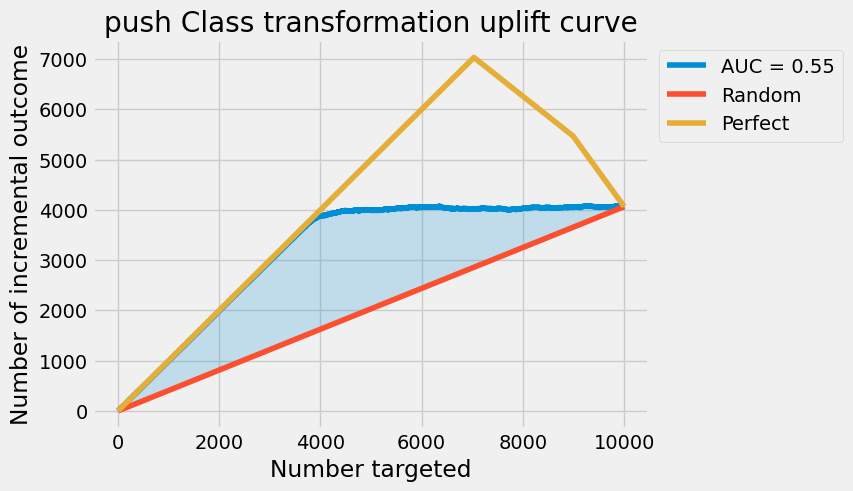

In [488]:
plot_uplift_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_ct_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Class transformation uplift curve')
plt.show()

In [494]:
qini_auc_score(y_true=push_test_encoded.remainder__target,
               uplift=pd.Series(uplift_ct_push, index=push_test_encoded.index),
               treatment=push_test_encoded['remainder__t_flag'])

0.3915975686078871

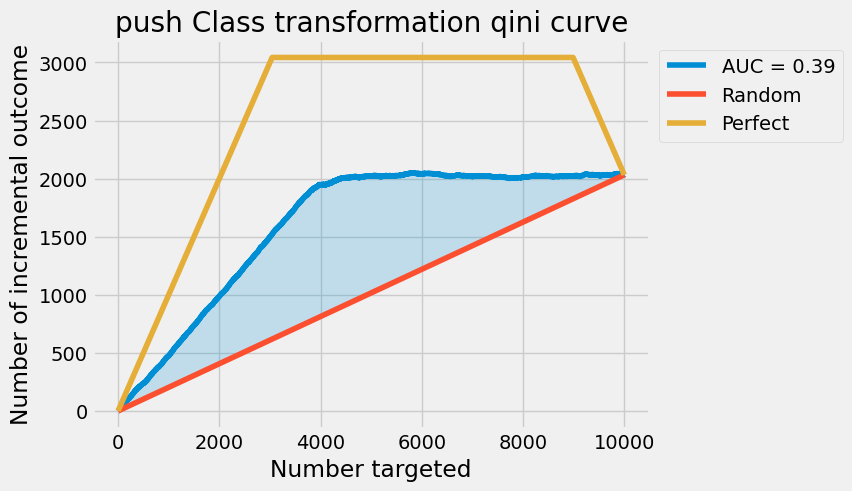

In [496]:
plot_qini_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_ct_push, index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Class transformation qini curve')
plt.show()

**banner**

In [498]:
ct_banner = ClassTransformation(model_1_cb_banner)
# fit the model
ct_banner = ct_banner.fit(banner_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'),
                banner_train_encoded.remainder__target,
                treatment=banner_train_encoded['remainder__t_flag'])
# predict uplift
uplift_ct_banner = ct_banner.predict(banner_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

**banner** метрики

In [501]:
uplift_at_k(y_true=banner_test_encoded.remainder__target,
            uplift=uplift_ct_banner,
            treatment=banner_test_encoded['remainder__t_flag'],
            strategy='by_group',
            k=0.2)

0.9613333333333334

In [505]:
uplift_auc_score(y_true=banner_test_encoded.remainder__target,
                 uplift=uplift_ct_banner,
                 treatment=banner_test_encoded['remainder__t_flag'])

0.3127329163873241

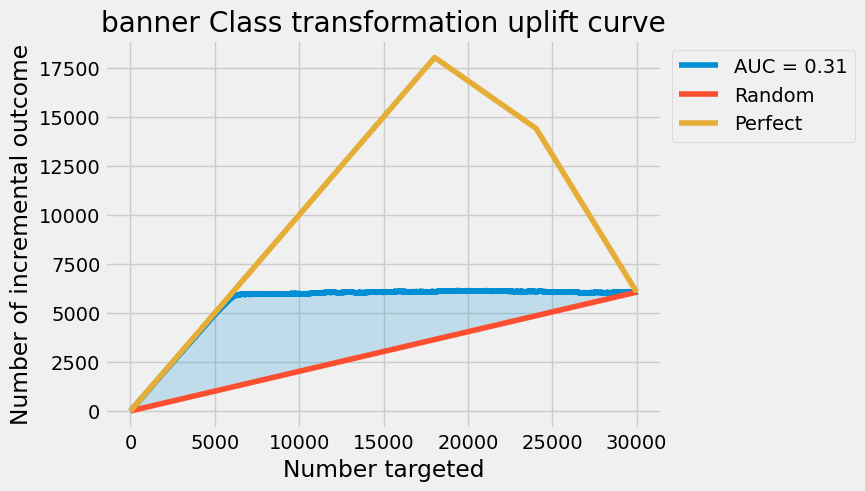

In [507]:
plot_uplift_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_ct_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Class transformation uplift curve')
plt.show()

In [509]:
qini_auc_score(y_true=banner_test_encoded.remainder__target,
               uplift=pd.Series(uplift_ct_banner, index=banner_test_encoded.index),
               treatment=banner_test_encoded['remainder__t_flag'])

0.21475937277860013

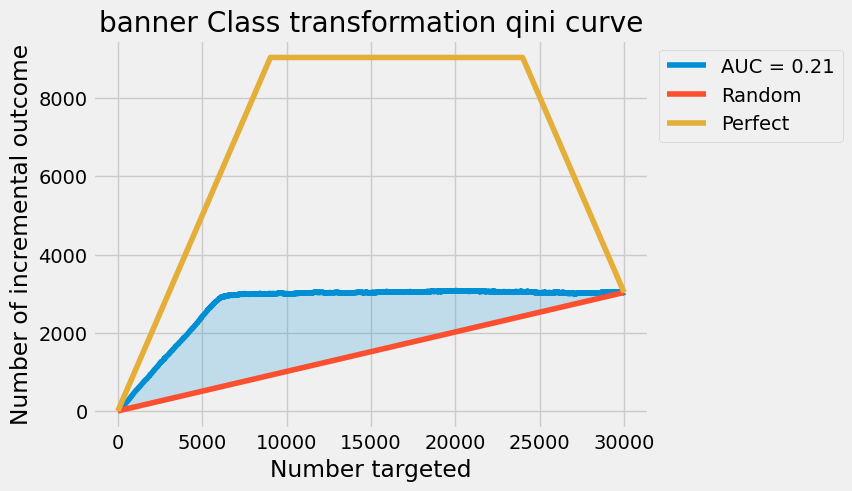

In [511]:
plot_qini_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_ct_banner, index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Class transformation qini curve')
plt.show()

#### UpliftRandomForest

In [513]:
uplift_forest_push = UpliftRandomForestClassifier(control_name='0',
                                             random_state=RANDOM_STATE)

In [515]:
uplift_forest_push.fit(X=push_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag').values,
                  y=push_train_encoded.remainder__target.values,
                  treatment=push_train_encoded['remainder__t_flag'].astype('int').astype('str').values)

In [517]:
uplift_rf_push = uplift_forest_push.predict(X=push_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag').values)

**push** метрики

In [520]:
uplift_at_k(y_true=push_test_encoded.remainder__target,
            uplift=uplift_rf_push.reshape(-1),
            treatment=push_test_encoded['remainder__t_flag'].astype(int),
            strategy='by_group',
            k=0.2)

0.993

In [522]:
uplift_auc_score(y_true=push_test_encoded.remainder__target,
                 uplift=uplift_rf_push.reshape(-1),
                 treatment=push_test_encoded['remainder__t_flag'].astype(int))

0.5220660688087856

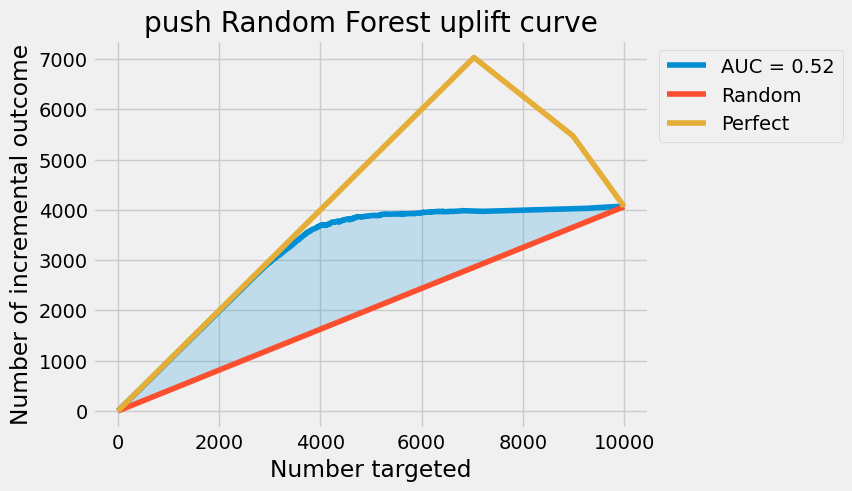

In [524]:
plot_uplift_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_rf_push.reshape(-1), index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'])
plt.title('push Random Forest uplift curve')
plt.show()

In [530]:
qini_auc_score(y_true=push_test_encoded.remainder__target,
               uplift=pd.Series(uplift_rf_push.reshape(-1), index=push_test_encoded.index),
               treatment=push_test_encoded['remainder__t_flag'].astype(int))

0.3735932121243138

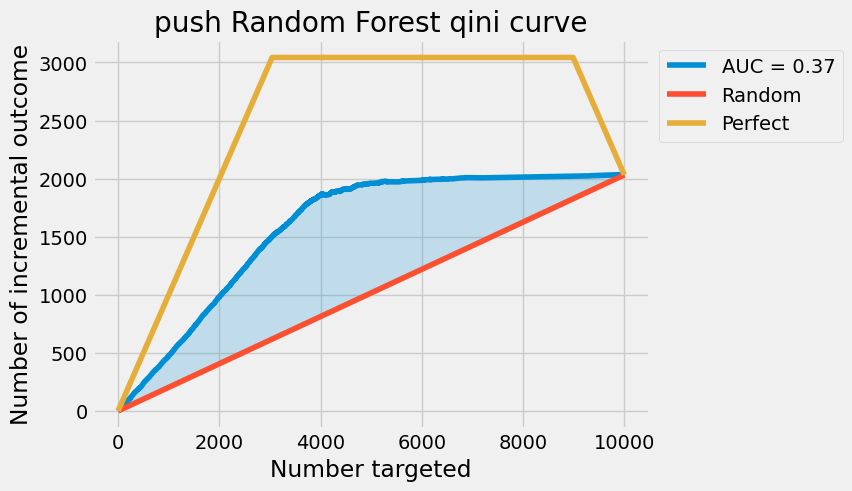

In [532]:
plot_qini_curve(y_true=push_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_rf_push.reshape(-1), index=push_test_encoded.index),
                  treatment=push_test_encoded['remainder__t_flag'].astype(int))
plt.title('push Random Forest qini curve')
plt.show()

**banner**

In [535]:
uplift_forest_banner = UpliftRandomForestClassifier(control_name='0',
                                             random_state=RANDOM_STATE)


uplift_forest_banner.fit(X=banner_train_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag').values,
                  y=banner_train_encoded.remainder__target.values,
                  treatment=banner_train_encoded['remainder__t_flag'].astype('int').astype('str').values)


uplift_rf_banner = uplift_forest_banner.predict(X=banner_test_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag').values)


**banner** метрики

In [540]:
uplift_at_k(y_true=banner_test_encoded.remainder__target,
            uplift=uplift_rf_banner.reshape(-1),
            treatment=banner_test_encoded['remainder__t_flag'].astype(int),
            strategy='by_group',
            k=0.2)

0.9043333333333333

In [544]:
uplift_auc_score(y_true=banner_test_encoded.remainder__target,
                 uplift=uplift_rf_banner.reshape(-1),
                 treatment=banner_test_encoded['remainder__t_flag'].astype(int))

0.3027871331769357

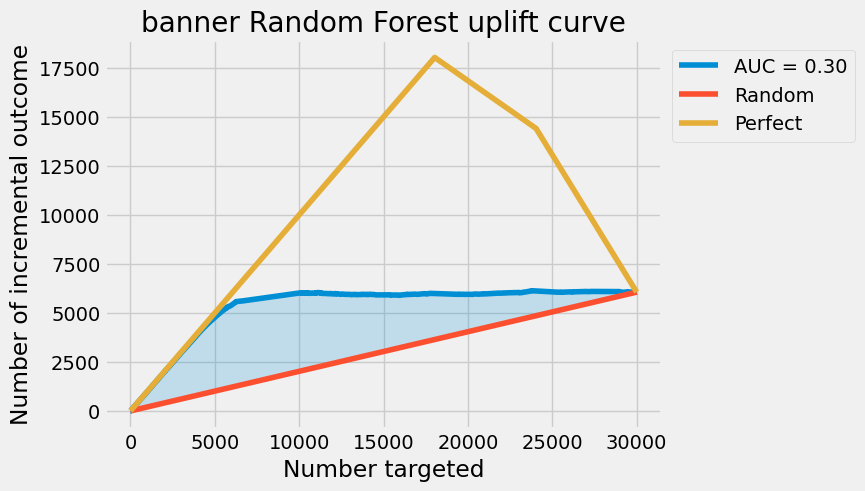

In [546]:
plot_uplift_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_rf_banner.reshape(-1), index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'])
plt.title('banner Random Forest uplift curve')
plt.show()

In [548]:
qini_auc_score(y_true=banner_test_encoded.remainder__target,
               uplift=pd.Series(uplift_rf_banner.reshape(-1), index=banner_test_encoded.index),
               treatment=banner_test_encoded['remainder__t_flag'].astype(int))

0.21104063767028727

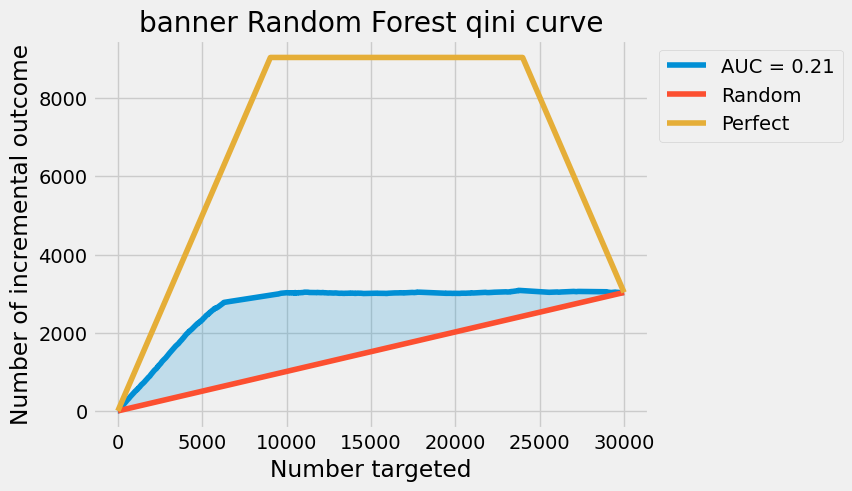

In [550]:
plot_qini_curve(y_true=banner_test_encoded.remainder__target,
                  uplift=pd.Series(uplift_rf_banner.reshape(-1), index=banner_test_encoded.index),
                  treatment=banner_test_encoded['remainder__t_flag'].astype(int))
plt.title('banner Random Forest qini curve')
plt.show()

In [558]:
models_metrics = pd.DataFrame(columns=['uplift_at_k PUSH', 'uplift_at_k BANNER', 'uplift_auc_score PUSH', 'uplift_auc_score BANNER', 'qini_auc_score PUSH', 'qini_auc_score BANNER'],
                 index=['Solomodel','Solomodel из библиотеки Sklift','Metalearners: Twomodels pipeline','Metalearners: CatBoostClassifier и калибровка','ClassTransformation', 'UpliftRandomForest']
                 )

In [564]:
models_metrics.loc['Solomodel'] = [0.64, 0.83, 0.29, 0.29, 0.19, 0.20]
models_metrics.loc['Solomodel из библиотеки Sklift'] = [0.64, 0.83, 0.29, 0.29, 0.19, 0.20]
models_metrics.loc['Metalearners: Twomodels pipeline'] = [0.99, 0.96, 0.53, 0.3, 0.38, 0.21]
models_metrics.loc['Metalearners: CatBoostClassifier и калибровка'] = [0.99, 0.97, 0.54, 0.3, 0.38, 0.21]
models_metrics.loc['ClassTransformation'] = [0.99, 0.96, 0.54, 0.31, 0.39, 0.21]
models_metrics.loc['UpliftRandomForest'] = [0.99, 0.9, 0.52, 0.3, 0.37, 0.21]
models_metrics

,uplift_at_k PUSH,uplift_at_k BANNER,uplift_auc_score PUSH,uplift_auc_score BANNER,qini_auc_score PUSH,qini_auc_score BANNER
Solomodel,0.64,0.83,0.29,0.29,0.19,0.2
Solomodel из библиотеки Sklift,0.64,0.83,0.29,0.29,0.19,0.2
Metalearners: Twomodels pipeline,0.99,0.96,0.53,0.3,0.38,0.21
Metalearners: CatBoostClassifier и калибровка,0.99,0.97,0.54,0.3,0.38,0.21
ClassTransformation,0.99,0.96,0.54,0.31,0.39,0.21
UpliftRandomForest,0.99,0.9,0.52,0.3,0.37,0.21


ClassTransformation Uplift показывает лучшее качество.

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [309]:
features_january['t_flag']=np.nan
features_january['target']=np.nan

In [311]:
features_january.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city,t_flag,target
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa,NaN,NaN
19,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,2025-01-31,25872,42,Moscow,NaN,NaN
48,1.262071,-0.590011,-1.487096,-0.966672,2.740715,0.312791,-0.356535,-0.539563,1.401530,2025-01-31,4107442,28,Smolensk,NaN,NaN
66,-6.942073,0.107627,1.760962,4.424731,1.980637,0.238544,-1.329872,0.288694,-1.625620,2025-01-31,2047420,32,Moscow,NaN,NaN
67,-2.200147,0.694959,-1.620087,4.003986,0.808261,0.214216,-0.330887,-1.386118,1.525752,2025-01-31,1120643,22,Ufa,NaN,NaN


In [313]:
features_january_banner_encoded = pd.DataFrame(ct_banner.transform(features_january),
                          columns=ct_banner.get_feature_names_out(),
                          index=features_january.index)
features_january_banner_encoded.head()

,onehot__city_Moscow,onehot__city_Smolensk,onehot__city_Ufa,remainder__x1,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__age,remainder__t_flag,remainder__target
0,0.0,0.0,1.0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,26.0,NaN,NaN
19,1.0,0.0,0.0,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,42.0,NaN,NaN
48,0.0,1.0,0.0,1.262071,-0.590011,-1.487096,-0.966672,2.740715,0.312791,-0.356535,-0.539563,1.401530,28.0,NaN,NaN
66,1.0,0.0,0.0,-6.942073,0.107627,1.760962,4.424731,1.980637,0.238544,-1.329872,0.288694,-1.625620,32.0,NaN,NaN
67,0.0,0.0,1.0,-2.200147,0.694959,-1.620087,4.003986,0.808261,0.214216,-0.330887,-1.386118,1.525752,22.0,NaN,NaN


In [315]:
features_january_push_encoded = pd.DataFrame(ct_push.transform(features_january),
                          columns=ct_push.get_feature_names_out(),
                          index=features_january.index)
features_january_push_encoded.head()

,onehot__city_Moscow,onehot__city_Smolensk,onehot__city_Ufa,remainder__x1,remainder__x2,remainder__x3,remainder__x4,remainder__x5,remainder__x6,remainder__x7,remainder__x8,remainder__x9,remainder__age,remainder__t_flag,remainder__target
0,0.0,0.0,1.0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,26.0,NaN,NaN
19,1.0,0.0,0.0,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,42.0,NaN,NaN
48,0.0,1.0,0.0,1.262071,-0.590011,-1.487096,-0.966672,2.740715,0.312791,-0.356535,-0.539563,1.401530,28.0,NaN,NaN
66,1.0,0.0,0.0,-6.942073,0.107627,1.760962,4.424731,1.980637,0.238544,-1.329872,0.288694,-1.625620,32.0,NaN,NaN
67,0.0,0.0,1.0,-2.200147,0.694959,-1.620087,4.003986,0.808261,0.214216,-0.330887,-1.386118,1.525752,22.0,NaN,NaN


In [573]:
predict_push = ct_push.predict(features_january_push_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

In [577]:
predict_banner = ct_banner.predict(features_january_banner_encoded.drop(columns = 'remainder__target').drop(columns='remainder__t_flag'))

In [579]:
answer = pd.DataFrame(columns=['user_id', 'report_dt', 'channel','uplift', 'push', 'banner'])

In [587]:
def find_channel(x):
    m = max(x['push'], x['banner'])
    if m <= 0:
        return 'no_comm'
    else:
        if m == x['push']:
            return 'push'
        else:
            return 'banner'
    

In [591]:
answer['user_id'] = features_january['user_id']
answer['report_dt'] = '2025-01-31'
answer['push'] = predict_push
answer['banner'] = predict_banner
answer['uplift'] = answer[['push', 'banner']].apply(lambda x: max(x['push'], x['banner']), axis=1)
answer['channel'] = answer[['push', 'banner']].apply(lambda x: find_channel(x), axis=1)
del answer['push']
del answer['banner']
answer

,user_id,report_dt,channel,uplift
0,1066338,2025-01-31,push,0.237090
19,25872,2025-01-31,banner,0.144600
48,4107442,2025-01-31,push,0.863460
66,2047420,2025-01-31,push,0.924857
67,1120643,2025-01-31,banner,0.325505
...,...,...,...,...
2759961,4034876,2025-01-31,push,0.516851
2759983,114148,2025-01-31,push,0.986149
2759991,143255,2025-01-31,banner,0.561436
2759996,132172,2025-01-31,push,0.196201


In [593]:
answer['channel'].value_counts()

channel
push       342503
banner     104444
no_comm     13053
Name: count, dtype: int64

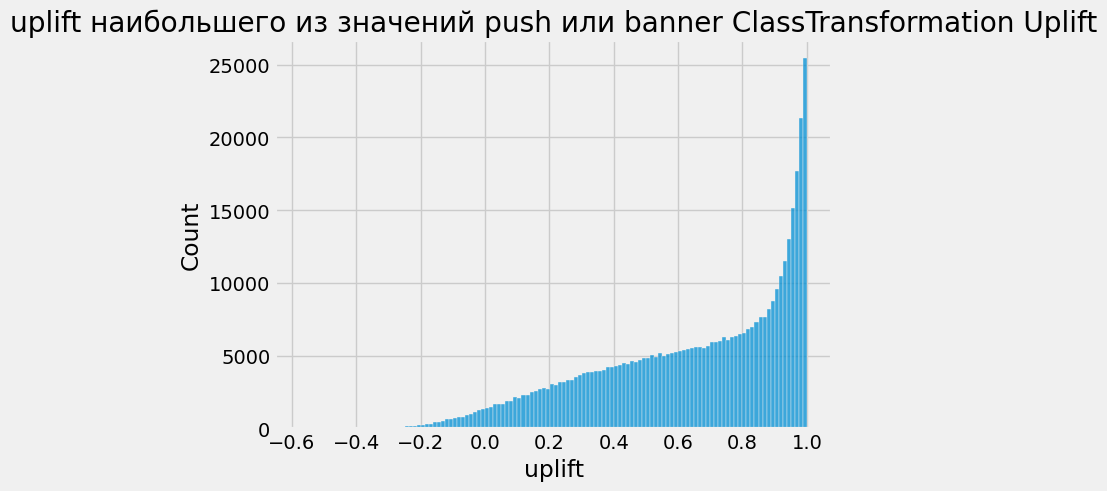

In [596]:
uplift_pd = pd.DataFrame(data = answer['uplift'], index = answer.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=answer['uplift']).set_title('uplift наибольшего из значений push или banner ClassTransformation Uplift')
plt.show()

### ваши выводы здесь

Распределение по каналам отправки коммуникации:

push       342503

banner     104444

no_comm     13053 (коммуникация не отправляется, так как аплифт меньше либо равен нулю).


Я думаю, что некорректно говорить о наиболее предпочтительном канале для всех клиентов.
Мы выявили 342503 клиента, для которых предпочтиельным является канал push.
Мы выявили 104444 клиента, для которых предпочтиельным является канал banner.
А для 13053 клиентов мы не рекомедуем отправлять коммуникацию ни по одному из исследованных каналов, так как аплифт меньше либо равен нулю и коммуникация может оказать негативное воздейтсвие на клиента и привести к его потере.

Гистограмма максимального значения uplift имеет форму распределения смещённую вправо. Большинство клиентов имеют низкие или отрицательные значения uplift, а небольшая группа имеет очень высокие значения uplift. Это хороший признак, так как указывает на то, что модель хорошо выявляет пользователей, которые сильно реагируют на воздействие по каналам push или banner.

В процессе работы удалось получить хорошее качество и на иных моделях.

In [598]:
models_metrics

,uplift_at_k PUSH,uplift_at_k BANNER,uplift_auc_score PUSH,uplift_auc_score BANNER,qini_auc_score PUSH,qini_auc_score BANNER
Solomodel,0.64,0.83,0.29,0.29,0.19,0.2
Solomodel из библиотеки Sklift,0.64,0.83,0.29,0.29,0.19,0.2
Metalearners: Twomodels pipeline,0.99,0.96,0.53,0.3,0.38,0.21
Metalearners: CatBoostClassifier и калибровка,0.99,0.97,0.54,0.3,0.38,0.21
ClassTransformation,0.99,0.96,0.54,0.31,0.39,0.21
UpliftRandomForest,0.99,0.9,0.52,0.3,0.37,0.21
